<!-- Centered layout with a university logo -->
<div align="center">

  <!-- University Logo -->
  <img src="https://cdn.freebiesupply.com/logos/large/2x/sharif-logo-png-transparent.png" width="180" height="180" style="margin-bottom: 10px;">
  
  <!-- Assignment Title -->
  <h1></h1>
  <h1 style="color:#0F5298; font-size: 40px; font-weight: bold; margin-bottom: 5px;">Deep Reinforcement Learning</h1>
  <h2 style="color:#0F5298; font-size: 32px; font-weight: normal; margin-top: 0px;">Assignment 06 - Multi-Armed and Contextual Bandits</h2>

  <!-- Department and University -->
  <h3 style="color:#696880; font-size: 24px; margin-top: 20px;">Computer Engineering Department</h3>
  <h3 style="color:#696880; font-size: 22px; margin-top: -5px;">Sharif University of Technology</h3>

  <!-- Semester -->
  <h3 style="color:#696880; font-size: 22px; margin-top: 20px;">Spring 2025</h3>

  <!-- Authors -->
  <h3 style="color:green; font-size: 22px; margin-top: 20px;">Full name: Asemaneh Nafe[FULL_NAME]</h3>
  <h3 style="color:green; font-size: 22px; margin-top: 20px;">Student ID: 400105285[STUDENT_ID]</h3>

  <!-- Horizontal Line for Separation -->
  <hr style="border: 1px solid #0F5298; width: 80%; margin-top: 30px;">

</div>


## Setup & Overview  
In this notebook, we simulate bandit problems using *MAB* (Multi-Armed Bandit) and *CtxBnd* (Contextual Bandit) frameworks.  
We compare several agents:
- **Oracle** (with privileged info)
- **RndAg** (Random Agent)
- **ExpFstAg** (Explore-First Agent)
- **UCB_Ag** (UCB Agent)
- **EpsGdAg** (Epsilon-Greedy Agent)
- **LinUCB_Ag** (LinUCB for contextual bandits)


Follow the instructions carefully and complete the sections marked with **TODO**.

## Setup and Environment

In the upcoming cells, we import necessary libraries, set up utility functions for reproducibility and plotting, and define the basic components of our bandit experiments.


In [ ]:
#with help of chat gpt
# %% [code]
import numpy as np
import random
import time
import os
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from dataclasses import dataclass
from copy import deepcopy
from tqdm.notebook import tqdm

plt.rcParams['figure.dpi'] = 100

In [ ]:
# %% [code]
def plot_logs(df, x_key, y_key, legend_key, **kwargs):
    num = len(df[legend_key].unique())
    pal = sns.color_palette("hls", num)
    if 'palette' not in kwargs:
        kwargs['palette'] = pal
    ax = sns.lineplot(x=x_key, y=y_key, data=df, hue=legend_key, **kwargs)
    return ax

def set_seed(s):
    np.random.seed(s)
    random.seed(s)

set_seed(0)

## MAB Overview  
We consider a bandit with 10 arms. Two formulations:  
- **Stochastic:** Each arm gives a reward of 1 with probability *p*.  
- **Deterministic:** Each arm always returns a fixed reward.  
  
We'll work with the stochastic case. The reward probabilities will be set randomly.

In [ ]:
# %% [code]
nArms = 10
p_arr = [np.random.random() for _ in range(nArms)]
print("Probabilities:", p_arr)

Probabilities: [0.5488135039273248, 0.7151893663724195, 0.6027633760716439, 0.5448831829968969, 0.4236547993389047, 0.6458941130666561, 0.4375872112626925, 0.8917730007820798, 0.9636627605010293, 0.3834415188257777]


**Q:** How might the performance of different agents change if the distribution of probabilities were not uniform?  

**A:** If the distribution of arm probabilities is not uniform—say, skewed where a few arms have high probabilities and most have low ones—the performance of agents will change noticeably:

Oracle would still perform best, unaffected by distribution, since it knows the optimal arm from the start.

RndAg (Random Agent) would likely perform worse on average in a skewed distribution because it has no mechanism to prefer better arms and might frequently sample poor ones.

ExpFstAg (Explore-First) may do well if the exploration phase samples enough of the high-reward arms. However, if the best arms are rare and missed during initial exploration, the agent could commit to suboptimal ones during exploitation.

UCB_Ag (Upper Confidence Bound Agent) is designed to balance exploration and exploitation, so it should adapt well even in skewed settings, though it might initially waste effort on poor arms until confidence bounds narrow.

EpsGdAg (Epsilon-Greedy) could suffer slightly if the best arms are rare and ε is too low, leading to insufficient exploration. A higher ε might help it find good arms but at the cost of more random plays.

LinUCB_Ag (for contextual settings) would adapt based on context, so if certain contexts are associated with better arms, it could learn these patterns, assuming there's enough exploration.

Overall, skewed distributions amplify the importance of effective exploration. Agents that explore more intelligently tend to perform better in such environments.


In [ ]:
# %% [code]
@dataclass
class MAB_Env:
    p_arr: np.ndarray

    def step(self, act):
        return 1 if np.random.random() < self.p_arr[act] else 0

**Q:** Why does the MAB environment use a simple binary reward mechanism (1 or 0)?

**A:**
The MAB environment uses a simple binary reward mechanism (1 or 0) because it keeps the problem intuitive and focused on core learning objectives. This binary setup makes it easy to understand whether an action was successful or not, mirroring many real-world applications like ad clicks, user engagement, or treatment outcomes where results are inherently binary. It also simplifies the mathematical modeling, allowing algorithms to focus on estimating success probabilities rather than handling complex reward distributions. Using binary rewards reduces noise and makes the behavior of different agents easier to analyze and compare, especially in early experimentation. Moreover, it aligns well with the Bernoulli distribution framework, making the analysis of regret, convergence, and exploration strategies more straightforward. Many foundational results in bandit theory, such as bounds on cumulative regret or optimal exploration-exploitation trade-offs, are derived under binary reward assumptions. This helps researchers and learners focus on key ideas without being distracted by variability in reward magnitude. While real-world problems can involve continuous rewards, starting with a binary setup provides a clear and controlled environment to study the effectiveness of different decision-making strategies.

In [ ]:
# %% [code]
@dataclass
class MAB_Eng:
    p_arr: np.ndarray
    max_steps: int
    agent: any

    def __post_init__(self):
        self.env = MAB_Env(p_arr=self.p_arr)

    def run(self, n_runs=1):
        logs = []
        for _ in tqdm(range(n_runs), desc='Runs'):
            run_rewards = []
            run_acts = []
            self.agent.reset()
            for t in range(self.max_steps):
                act = self.agent.get_action()
                rew = self.env.step(act)
                self.agent.update_Q(act, rew)
                run_acts.append(act)
                run_rewards.append(rew)
            logs.append(pd.DataFrame({
                'reward': run_rewards,
                'action': run_acts,
                'step': np.arange(len(run_rewards))
            }))
        return pd.concat(logs, ignore_index=True)

In [ ]:
# %% [code]
def mab_swp(agents, p_arr, labels, n_runs=2000, max_steps=500):
    all_logs = []
    for idx, agent in enumerate(tqdm(agents, desc="Alg Sweeps")):
        engine = MAB_Eng(p_arr=p_arr, max_steps=max_steps, agent=agent)
        log_df = engine.run(n_runs)
        log_df['Alg'] = labels[idx]
        all_logs.append(log_df)
    return pd.concat(all_logs, ignore_index=True)

## Oracle Agent  
The **Oracle** has full knowledge of *p_arr*.  
**Question:** What is the maximum expected per-step reward?
The Oracle agent has full access to the true reward probabilities of all arms, meaning it knows exactly which arm has the highest probability of returning a reward. Since it's not limited by uncertainty or the need to explore, it will always choose the best arm—the one with the highest probability of success.

The expected per-step reward for the Oracle is therefore equal to the maximum value in p_arr, which represents the probability of success for the best arm. For example, if p_arr = [0.2, 0.5, 0.8, 0.3, ...], the Oracle will always choose the arm with 0.8 probability, giving it an expected reward of 0.8 at every step.

So, the maximum expected per-step reward is simply: max(p_arr)
This value will be between 0 and 1, depending on how the probabilities were initialized. The Oracle acts as the upper bound for all other agents—it represents the best any agent could theoretically do in the long run

In [ ]:
# TODO: Compute oracleReward using privileged info (simple placeholder)
oracleReward =  max(p_arr)   # Placeholder
print(f'Max possible reward (Simple): {oracleReward}')

Max possible reward (Simple): 0.9636627605010293


**Q:** What insight does the oracle reward give us about the best possible performance?

**A:** The oracle reward tells us the absolute upper limit of performance that any agent could achieve in this environment. Since the Oracle always pulls the best possible arm, its expected per-step reward reflects the highest average reward achievable. This acts as a benchmark or gold standard against which we can compare the performance of learning agents. If another agent performs close to the oracle, it means it has learned the optimal policy effectively. On the other hand, a big gap shows that the agent still struggles with exploration or exploitation.

-------------------

**Q:** Why is the oracle considered “cheating” in a practical sense?  

**A:** The oracle is considered "cheating" because it has access to information that a real-world agent wouldn’t know in advance—namely, the exact success probabilities of each arm. In real applications, agents must learn about the environment through trial and error. The Oracle doesn’t need to explore or make uncertain decisions; it skips the learning phase entirely. So, while it helps us understand what's theoretically possible, it's not realistic to use as a practical solution in most real scenarios.

## RndAg (Random Agent)  
This agent selects an action at random at every timestep. It does no learning.


In [ ]:
@dataclass
class RndAg:
    n_act: int

    def __post_init__(self):
        self.reset()

    def reset(self):
        self.t = 0
        self.act_counts = np.zeros(self.n_act, dtype=int)
        self.Q = np.zeros(self.n_act, dtype=float)

    def update_Q(self, act, rew):
        pass  # No learning

    def get_action(self):
        self.t += 1
        # TODO: get a random action index [Simple]
        sel_act = np.random.randint(self.n_act)  # Select a random action index
        return sel_act

In [ ]:
# %% [code]
rnd_agent = RndAg(n_act=len(p_arr))
n_runs = 1000
rnd_log = mab_swp([rnd_agent], p_arr, ['Rnd'], n_runs=n_runs)

Alg Sweeps:   0%|          | 0/1 [00:00<?, ?it/s]

Runs:   0%|          | 0/1000 [00:00<?, ?it/s]

<ipython-input-2-cea5b34d9fd8>:7: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.lineplot(x=x_key, y=y_key, data=df, hue=legend_key, **kwargs)


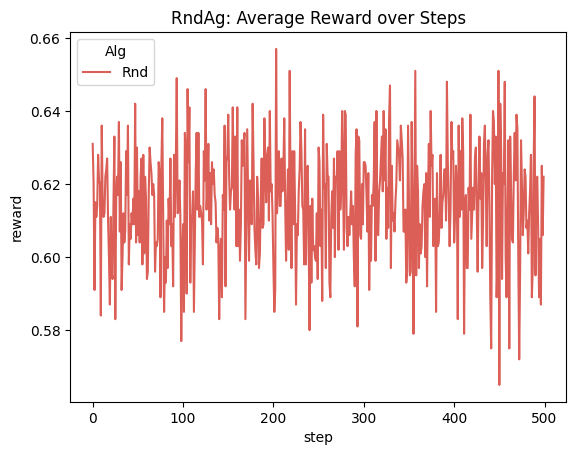

In [ ]:
# %% [code]
plot_logs(rnd_log, x_key='step', y_key='reward', legend_key='Alg', estimator='mean', ci=None)
plt.title("RndAg: Average Reward over Steps")
plt.show()

**Q:** Why is the reward of the random agent generally lower and highly variable?

**A:** The random agent doesn’t try to learn which arms are better—it just picks actions at random every time. This means it has no preference for high-reward arms and might frequently choose poor ones. Because of this, its average reward tends to be lower compared to agents that actively learn from feedback. Also, since the actions are chosen blindly, the results vary a lot across different runs. Sometimes it may hit a good arm more often by chance, and other times it might keep choosing weak ones, leading to high variability in performance.

------------

**Q:** How might you improve a random agent without using any learning mechanism?

**A:** Even without actual learning, a random agent could be improved slightly by incorporating some simple rules or biases. For example, it could avoid repeating the same arm too often by cycling through arms more evenly (e.g., round-robin selection). Another idea is to assign fixed probabilities to each arm based on some prior belief or heuristic, instead of choosing uniformly at random. While these approaches don’t adapt over time, they can prevent the agent from getting stuck in poor action patterns purely due to bad luck.

<ipython-input-2-cea5b34d9fd8>:7: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.lineplot(x=x_key, y=y_key, data=df, hue=legend_key, **kwargs)


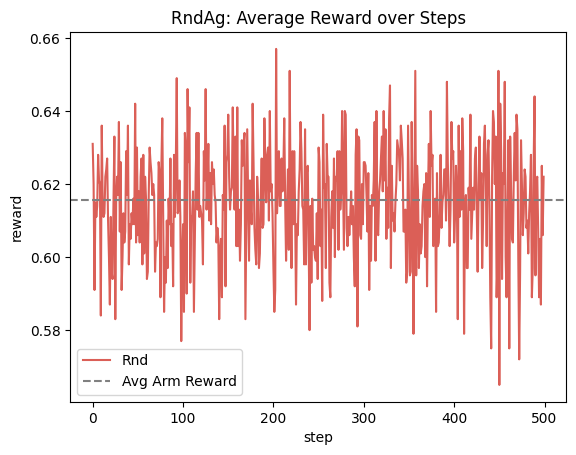

In [ ]:
# TODO: Plot RndAg reward curve and average reward of all arms (Simple)
avg_arm_reward = np.mean(p_arr)

# Plot the random agent's reward curve
plot_logs(rnd_log, x_key='step', y_key='reward', legend_key='Alg', estimator='mean', ci=None)

# Add a horizontal line for the average reward of all arms
plt.axhline(y=avg_arm_reward, color='gray', linestyle='--', label='Avg Arm Reward')

plt.title("RndAg: Average Reward over Steps")
plt.legend()
plt.show()

**Analysis:**  
- The x-axis shows the number of steps; y-axis shows average reward.  
- Regret is the gap between Oracle and agent performance.

## ExpFstAg (Explore-First Agent)  
This agent explores randomly for the first *max_ex* steps, then exploits the best arm thereafter.

In [ ]:
@dataclass
class ExpFstAg:
    n_act: int
    max_ex: int

    def __post_init__(self):
        self.reset()

    def reset(self):
        self.t = 0
        self.act_counts = np.zeros(self.n_act, dtype=int)
        self.Q = np.zeros(self.n_act, dtype=float)

    def update_Q(self, act, rew):
        self.act_counts[act] += 1
        count = self.act_counts[act]
        self.Q[act] += (rew - self.Q[act]) / count  # Incremental average

    def get_action(self):
        self.t += 1
        if self.t <= self.max_ex:
            sel_act = np.random.randint(self.n_act)  # Explore randomly
        else:
            sel_act = np.argmax(self.Q)  # Exploit the best arm
        return sel_act

### Run ExpFstAg with max_ex = 5  
We will test ExpFstAg (with 5 exploration steps) over 1000 runs and 500 steps.

Alg Sweeps:   0%|          | 0/1 [00:00<?, ?it/s]

Runs:   0%|          | 0/1000 [00:00<?, ?it/s]

<ipython-input-2-cea5b34d9fd8>:7: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.lineplot(x=x_key, y=y_key, data=df, hue=legend_key, **kwargs)


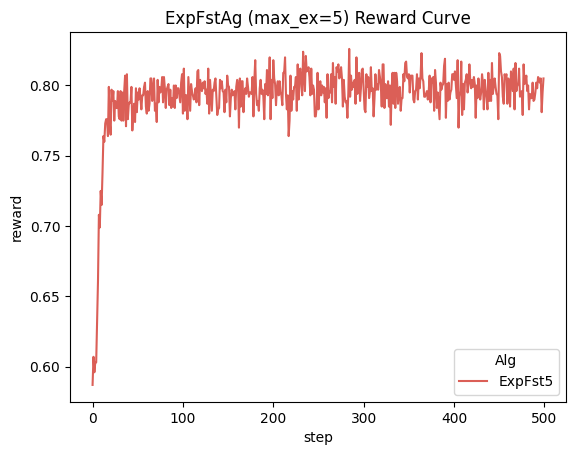

In [ ]:
# %% [code]
max_ex = 5
expfst_agent = ExpFstAg(n_act=len(p_arr), max_ex=max_ex)
expfst_log = mab_swp([expfst_agent], p_arr, [f'ExpFst{max_ex}'], n_runs=1000, max_steps=500)
plot_logs(expfst_log, x_key='step', y_key='reward', legend_key='Alg', estimator='mean', ci=None)
plt.title(f"ExpFstAg (max_ex={max_ex}) Reward Curve")
plt.show()

**Analysis:**  
- The ExpFstAg should outperform RndAg by identifying the best arm during exploration.  
- However, with too short exploration, it may miss the best arm.

----------

**Q:** Why might the early exploration phase (e.g., 5 steps) lead to high fluctuations in the reward curve?  


**A:** Because the agent is choosing actions completely at random during those first few steps, it has very limited information and no clear sense of which arms are good or bad. With only 5 random samples, it's quite possible that it doesn't pull the best arm at all—or only pulls it once by chance. As a result, when it switches to exploitation, it might latch onto an arm that seemed promising based on very limited data but isn't actually optimal. This can cause sudden jumps or drops in the reward curve early on, as the agent adjusts from exploration to what might be a poorly informed exploitation phase.

------------
**Q:** What are the trade-offs of using a fixed exploration phase?

A fixed exploration phase means the agent tries each option (arm) for a set number of steps before switching to full-on exploitation. It’s **simple, predictable**, and ensures the agent doesn’t start exploiting blindly. But it’s also pretty **rigid** — and that’s where the trade-offs come in.


**Pros: Why You Might Use It**
- **Easy to Implement**: You know exactly how long the exploration phase will last — no surprises.
- **Guaranteed Exploration**: Ensures the agent collects *some* data on all arms before choosing which to exploit.
- **Stable Setup for Theoretical Analysis**: It's clean and predictable, which makes it easier to analyze and benchmark.

**Cons: Why It Can Backfire**
- **Too Short?** You risk under-exploration. If the agent doesn’t sample the best arm during this short window, it might never discover it — especially in noisy environments. That means **you could get stuck exploiting a worse option**.
- **Too Long?** Now you're over-exploring. The agent keeps trying bad arms even when it's clear they're not worth it. That means **you waste time and lower your overall reward**.
- **No Flexibility**: It treats every problem the same way. Even if one arm gives consistently high rewards early on, the agent keeps exploring everything else. And if the signals are unclear, it still stops exploring after the fixed phase — even when more exploration might help.

 **The Core Trade-Off**
A fixed phase creates a **bias–variance dilemma**:
- **Shorter exploration** means **higher variance** in reward estimates — the Q-values might be way off.
- **Longer exploration** reduces variance, but increases **bias** — you spend time pulling clearly suboptimal arms.


A fixed exploration phase is like training wheels — great for simplicity, but not adaptive. In real-world scenarios where environments vary a lot, a more dynamic strategy (like switching based on Q-value stability or reward trends) will usually perform better in the long run.


Running ExpFstAg with max_ex=5...


Alg Sweeps:   0%|          | 0/1 [00:00<?, ?it/s]

Runs:   0%|          | 0/1000 [00:00<?, ?it/s]

Running ExpFstAg with max_ex=10...


Alg Sweeps:   0%|          | 0/1 [00:00<?, ?it/s]

Runs:   0%|          | 0/1000 [00:00<?, ?it/s]

Running ExpFstAg with max_ex=50...


Alg Sweeps:   0%|          | 0/1 [00:00<?, ?it/s]

Runs:   0%|          | 0/1000 [00:00<?, ?it/s]

Running ExpFstAg with max_ex=100...


Alg Sweeps:   0%|          | 0/1 [00:00<?, ?it/s]

Runs:   0%|          | 0/1000 [00:00<?, ?it/s]

Running ExpFstAg with max_ex=200...


Alg Sweeps:   0%|          | 0/1 [00:00<?, ?it/s]

Runs:   0%|          | 0/1000 [00:00<?, ?it/s]

<ipython-input-2-cea5b34d9fd8>:7: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.lineplot(x=x_key, y=y_key, data=df, hue=legend_key, **kwargs)


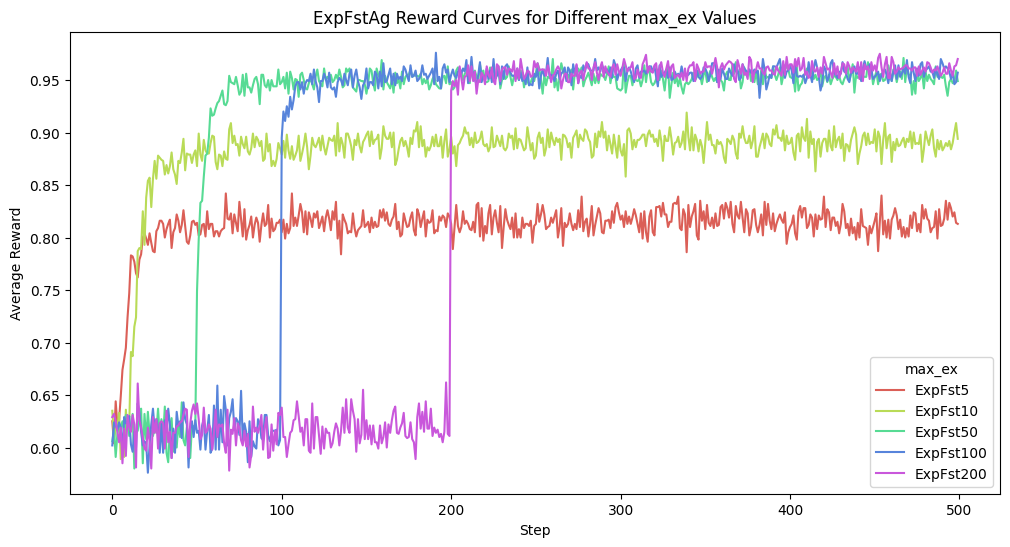

In [ ]:
# TODO: Run ExpFstAg for various max_ex values: [5, 10, 50, 100, 200] and plot all in one figure
max_ex_values = [5, 10, 50, 100, 200]
expfst_logs = []

# Run and collect logs
for ex in max_ex_values:
    print(f"Running ExpFstAg with max_ex={ex}...")
    agent = ExpFstAg(n_act=len(p_arr), max_ex=ex)
    log = mab_swp([agent], p_arr, [f'ExpFst{ex}'], n_runs=1000, max_steps=500)
    expfst_logs.append(log)

# Concatenate all logs into a single DataFrame for plotting
combined_log = pd.concat(expfst_logs, ignore_index=True)

# Plot all reward curves in one figure
plt.figure(figsize=(12, 6))
plot_logs(combined_log, x_key='step', y_key='reward', legend_key='Alg', estimator='mean', ci=None)
plt.title("ExpFstAg Reward Curves for Different max_ex Values")
plt.xlabel("Step")
plt.ylabel("Average Reward")
plt.legend(title="max_ex")
plt.show()


**Observations:**  
- Short exploration (e.g., 5 or 10 steps) may not reliably find the best arm.  
- Longer exploration (e.g., 50 or 100 steps) improves performance but may delay exploitation.

**Q:** How does increasing `max_ex` affect the convergence of the agent’s performance?


**A:**
As max_ex increases, the quality of the Q-value estimates improves.
With more exploration steps, each arm is sampled more times, and the law of large numbers helps the estimated means converge toward their true probabilities.

This reduces the risk of selecting a suboptimal arm during exploitation.
In other words, the agent becomes more confident in choosing the best arm once it exits the exploration phase.

However, there's a diminishing return:
Once the agent has sampled enough to reliably estimate which arm is best (say, the best arm has been pulled 10+ times and clearly stands out), further exploration adds little value and only delays the start of consistent rewards.

Mathematically, the cumulative regret initially increases with more exploration steps, since the agent continues pulling suboptimal arms.
But if the longer exploration helps lock onto the optimal arm later, the long-term average reward becomes higher, making the regret grow more slowly after convergence.

So, increasing max_ex helps the agent converge more accurately, but not necessarily faster—there’s a trade-off between early mistakes and late confidence.

------------------------------

**Q:** In real-world scenarios, what challenges might arise in selecting the optimal exploration duration?

**A:**
No prior knowledge:
In practice, we don’t know how many actions (arms) there are, how similar their reward distributions are, or how much variance exists in rewards. This makes it hard to pick a good max_ex.


Problem heterogeneity:
Different problems may require different levels of exploration. A fixed exploration phase doesn't adapt to environments where arms differ greatly in quality or where the best arm's advantage is subtle.


Non-stationary environments:
In dynamic settings (e.g., changing user behavior in a recommendation system), longer fixed exploration can be counterproductive since the “best” arm may change over time.


Delayed feedback:
In some applications (e.g., ad click prediction), you might not get immediate reward signals, making it hard to even know when max_ex has ended or if it was enough.


Cost of exploration:
Every non-optimal choice during exploration can incur a tangible cost—lost revenue, wasted resources, or poor user experience. Real-world systems often can’t afford many such losses.


Lack of adaptivity:
Fixed exploration doesn’t take advantage of strong early signals. For example, if one arm shows consistently high reward in the first few pulls, a smarter agent might stop exploring early—but this one can’t.

## UCB_Ag (UCB Agent)  
UCB dynamically balances exploration and exploitation by adding an exploration bonus to Q-values.

In [ ]:
from dataclasses import dataclass
import numpy as np

@dataclass
class UCB_Ag:
    n_act: int

    def __post_init__(self):
        self.reset()

    def reset(self):
        self.t = 0
        self.act_counts = np.zeros(self.n_act, dtype=int)
        self.Q = np.zeros(self.n_act, dtype=float)

    def update_Q(self, act, rew):
        self.act_counts[act] += 1
        n = self.act_counts[act]
        self.Q[act] += (rew - self.Q[act]) / n  # incremental average

    def get_action(self):
        self.t += 1
        delta = 1e-5  # to avoid division by zero
        bonus = np.sqrt(2 * np.log(self.t + 1) / (self.act_counts + delta))
        Q_explore = self.Q + bonus
        sel_act = np.random.choice(np.flatnonzero(Q_explore == Q_explore.max()))
        return sel_act


Alg Sweeps:   0%|          | 0/1 [00:00<?, ?it/s]

Runs:   0%|          | 0/1000 [00:00<?, ?it/s]

<ipython-input-2-cea5b34d9fd8>:7: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.lineplot(x=x_key, y=y_key, data=df, hue=legend_key, **kwargs)


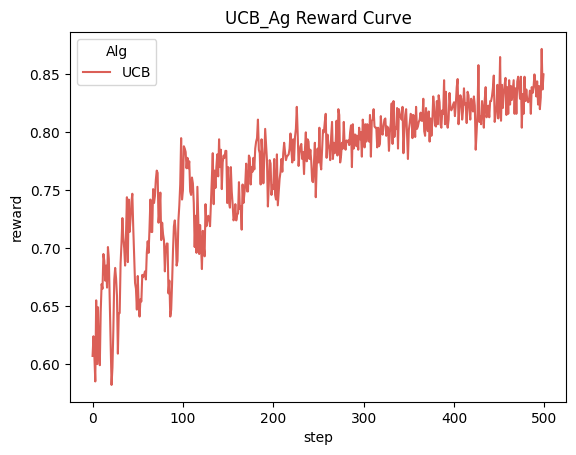

In [ ]:
# %% [code]
ucb_agent = UCB_Ag(n_act=len(p_arr))
ucb_log = mab_swp([ucb_agent], p_arr, ['UCB'], n_runs=1000, max_steps=500)
plot_logs(ucb_log, x_key='step', y_key='reward', legend_key='Alg', estimator='mean', ci=None)
plt.title("UCB_Ag Reward Curve")
plt.show()

**Q:** Under what conditions might an explore-first strategy outperform UCB, despite UCB’s theoretical optimality?

the two question are same as previous ones

**A:**
In very short time horizons, explore-first agents can outperform UCB because they focus their exploration early, then exploit consistently. If the best arm is correctly identified during the brief exploration phase, the remaining steps gain higher rewards with no further exploration cost.

UCB, although asymptotically optimal, continues to explore based on uncertainty. This may lead to unnecessary exploration in the short term, especially when it is confident enough but still adds exploration bonuses.

If the differences between arm reward probabilities (p_i) are large and easy to detect, even short exploration (like max_ex = 10) might be enough for ExpFstAg to identify the best arm. UCB might still spend time checking suboptimal arms to maintain theoretical guarantees.

infact An explore-first strategy might outperform UCB in certain practical situations where specific problem characteristics favor a simpler, more front-loaded approach to exploration. These conditions include:

Short Time Horizons:
When the number of total steps is small, UCB's exploration bonus can lead to over-exploration of suboptimal arms early on. An explore-first agent, with a fixed and short exploratory phase, can quickly switch to exploitation and potentially gain higher short-term cumulative rewards.

Clear Gaps Between Arms:
If one arm is significantly better than the others, even a brief exploration phase may be sufficient to identify it. In such scenarios, UCB might continue to allocate actions to clearly suboptimal arms due to its uncertainty estimates, while the explore-first agent can lock onto the best arm sooner.

Low Reward Variance:
When reward noise is low and samples are reliable, fewer data points are needed to confidently estimate an arm’s value. An explore-first agent benefits from this by needing fewer steps to identify the best option, whereas UCB may still "waste" steps on exploration due to its mathematical formulation.

Simplicity and Efficiency Constraints:
UCB requires continuous updates to confidence bounds and logs, which can be computationally expensive. An explore-first strategy is more efficient and deterministic, making it more suitable for environments with strict computation or memory limitations.


-----------------
**Q:** How do the design choices of each algorithm affect their performance in short-term versus long-term scenarios?

**A:**

Explore-First (ExpFstAg):

Short-Term: Can perform well if max_ex is appropriately tuned to identify the best arm quickly. But if exploration is too short, it risks locking into a suboptimal arm.

Long-Term: Not adaptive. Once it enters exploitation, it never revisits other arms—even if initial estimates were wrong. Poor performance if initial samples are misleading.

UCB:

Short-Term: Might underperform due to its continual exploration—revisiting arms it should have ruled out. This adds regret early on.

Long-Term: Performs better due to logarithmic regret growth. It adapts dynamically to new information and converges to optimal behavior.

## UCB vs. ExpFstAg  
Now we compare UCB_Ag and ExpFstAg (with max_ex = 5) side by side.


**Question:**  
Why does UCB learn slowly (even after 500 steps, not reaching maximum reward)?  
*Hint:* Consider the conservative nature of the exploration bonus.

The relatively slow learning pace of the UCB (Upper Confidence Bound) agent, even after 500 steps, is primarily due to its mathematically cautious approach to exploration. This behavior stems from the way UCB constructs and balances the trade-off between exploration and exploitation.


**Exploration Bonus Increases Logarithmically**  
UCB selects an action by combining its estimated reward with an exploration bonus that grows logarithmically over time and shrinks with the number of times the action has been selected. The formula is typically written as:
$
[
Q(a) + \sqrt{\frac{2 \log t}{N(a)}}
]
$
Here, \( Q(a) \) is the estimated mean reward for arm \( a \), \( t \) is the total number of steps, and \( N(a) \) is the number of times arm \( a \) has been pulled.

Because the logarithmic growth is slow, and the denominator $ \ \sqrt{N(a)} \ $ decreases slowly as \( N(a) \) grows, the exploration bonus decays conservatively. This causes the algorithm to continue exploring suboptimal arms for a longer time than necessary, especially early in the process when estimates are still uncertain.


**Conservative Exploration Leads to Over-exploration**  
UCB is designed to avoid missing the optimal arm by continuing to sample all arms that have not been explored sufficiently. While this provides theoretical guarantees about long-term regret minimization, it also means that UCB does not commit early, even if one arm appears clearly superior. This conservativeness can lead to over-exploration, where the algorithm continues testing weaker arms just to reduce uncertainty, even when the expected gain is marginal.



**Delayed Commitment to the Best Arm**  
Unlike Explore-First strategies, which deliberately stop exploring after a set number of steps and then exploit the empirically best arm, UCB never fully commits. This ongoing exploration can prevent it from capitalizing on the best arm early on, particularly in settings with a limited number of steps. As a result, its average reward may converge slowly, never fully reaching the maximum possible reward during shorter episodes like 500 steps.



**Sensitive to Noise and Close Arm Values**  
In environments where the reward variance is high or multiple arms have very similar expected rewards, the exploration bonus can dominate for longer periods. In these cases, UCB may repeatedly sample arms that have not clearly proven inferior, slowing down convergence even more. This is a byproduct of UCB’s emphasis on confidence intervals, which can remain wide in the presence of noisy or ambiguous reward distributions.


Running comparison between UCB_Ag and ExpFstAg (max_ex=5)...


Alg Sweeps:   0%|          | 0/2 [00:00<?, ?it/s]

Runs:   0%|          | 0/1000 [00:00<?, ?it/s]

Runs:   0%|          | 0/1000 [00:00<?, ?it/s]

<ipython-input-2-cea5b34d9fd8>:7: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.lineplot(x=x_key, y=y_key, data=df, hue=legend_key, **kwargs)


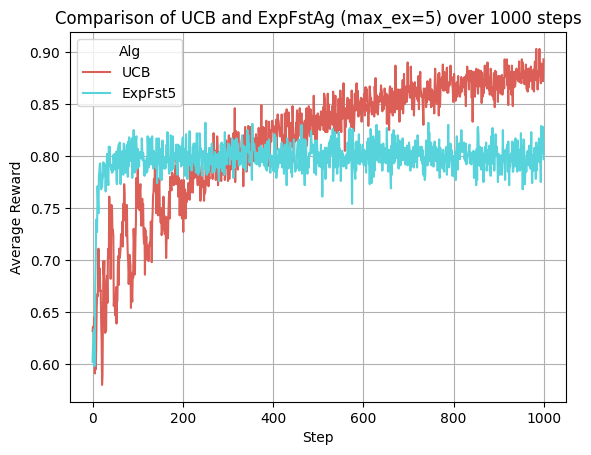

In [ ]:
# TODO: Run UCB_Ag and ExpFstAg (max_ex=5) for 1000 runs, 1000 steps (Simple placeholder)
# Define parameters
n_runs = 1000
max_steps = 1000
max_ex = 5

# Instantiate agents
ucb_agent = UCB_Ag(n_act=len(p_arr))
expfst_agent = ExpFstAg(n_act=len(p_arr), max_ex=max_ex)

# Run simulation
print("Running comparison between UCB_Ag and ExpFstAg (max_ex=5)...")
comparison_log = mab_swp(
    [ucb_agent, expfst_agent],
    p_arr,
    ['UCB', f'ExpFst{max_ex}'],
    n_runs=n_runs,
    max_steps=max_steps
)

# Plot the results
plot_logs(comparison_log, x_key='step', y_key='reward', legend_key='Alg', estimator='mean', ci=None)
plt.title(f"Comparison of UCB and ExpFstAg (max_ex={max_ex}) over {max_steps} steps")
plt.xlabel("Step")
plt.ylabel("Average Reward")
plt.grid(True)
plt.show()


**Q:** Under what conditions might an explore-first strategy outperform UCB, despite UCB’s theoretical optimality?

**A:**

Although UCB is theoretically optimal in minimizing regret over the long term, there are practical scenarios where an explore-first strategy can perform better:

- **Short Time Horizons:**
  In problems with a small number of total steps, UCB may spend too much time exploring due to its cautious bonus term. An explore-first strategy, if tuned well (e.g., with `max_ex = 5`), can quickly identify a decent arm and focus on exploitation, leading to higher cumulative rewards in the short run.

- **Large Gaps Between Arm Rewards:**
  If the best arm has a clearly higher mean reward than the others, a few exploration steps might be enough to identify it. Explore-first agents can lock in high performance early, while UCB may still be cautiously exploring.

- **Low Variance / Low Noise Settings:**
  When the rewards have low stochasticity, fewer samples are needed to accurately estimate true means. This benefits explore-first agents, as early exploration gives reliable estimates quickly.

- **Resource-Constrained Environments:**
  In scenarios where computational simplicity is valued (e.g., embedded systems), the explore-first approach avoids the ongoing overhead of computing UCB bonuses and logarithms, making it a practical alternative.


---------------

**Q:** How do the design choices of each algorithm affect their performance in short-term versus long-term scenarios?

**A:**

- **Explore-First Agent (ExpFstAg):**
  - *Short-Term:* Performs well if the `max_ex` is tuned appropriately, especially when there's a clear best arm or low noise. However, if `max_ex` is too small, the agent may fail to identify the best arm; if too large, it wastes time on suboptimal arms.
  - *Long-Term:* Lacks adaptability. Once the exploration phase ends, it commits to the perceived best arm, even if more data could prove that choice wrong. This can lead to suboptimal performance over long horizons, especially in high-variance environments.

- **UCB Agent:**
  - *Short-Term:* Conservative and often slower to exploit the best arm due to its cautious exploration bonus, leading to slightly lower rewards initially.
  - *Long-Term:* Designed for optimal performance with theoretical guarantees. It continuously refines its estimates and adapts as more data becomes available, minimizing regret effectively over time.


**Question:**  
What happens if we let ExpFstAg explore for 20 steps? Compare its reward to UCB.

If we let the ExpFstAg explore for 20 steps instead of just 5, it will have more opportunities to explore different actions before it starts exploiting the best arm. This means it will gather more information about the arms and potentially avoid early exploitation of suboptimal arms. However, this also delays the exploitation phase, and during the initial exploration steps, the agent might not be accumulating the maximum possible reward.

On the other hand, UCB dynamically balances exploration and exploitation. It explores arms with higher uncertainty in their expected rewards but starts exploiting the best arms earlier in the process by leveraging both the observed rewards and the uncertainty in action values. This allows UCB to take advantage of potentially good arms while still keeping track of the remaining uncertainty.

So, when comparing the two agents:

ExpFstAg with 20 exploration steps will likely gather more information before exploiting, but this delay in exploiting might result in slower convergence to the optimal arm, especially if it explores too long.

UCB, in contrast, will strike a balance between exploration and exploitation throughout the process, likely leading to faster convergence to the optimal arm compared to ExpFstAg with longer exploration.

Running comparison between UCB_Ag and ExpFstAg (max_ex=20)...


Alg Sweeps:   0%|          | 0/2 [00:00<?, ?it/s]

Runs:   0%|          | 0/1000 [00:00<?, ?it/s]

Runs:   0%|          | 0/1000 [00:00<?, ?it/s]

<ipython-input-2-cea5b34d9fd8>:7: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.lineplot(x=x_key, y=y_key, data=df, hue=legend_key, **kwargs)


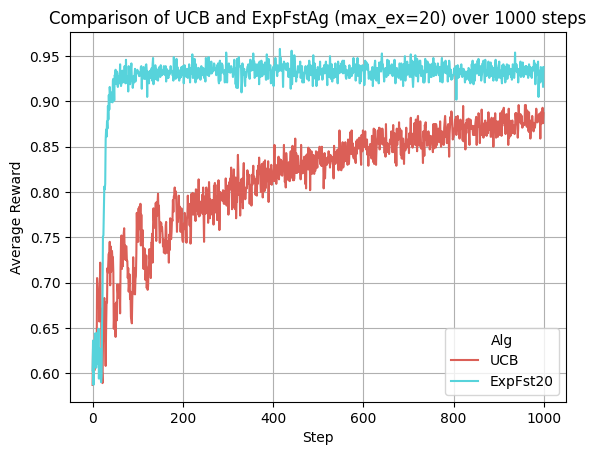

In [ ]:
# Define parameters for comparison
max_ex_20 = 20
n_runs = 1000
max_steps = 1000

# Instantiate agents
ucb_agent = UCB_Ag(n_act=len(p_arr))
expfst_agent_20 = ExpFstAg(n_act=len(p_arr), max_ex=max_ex_20)

# Run simulation
print("Running comparison between UCB_Ag and ExpFstAg (max_ex=20)...")
comparison_log_20 = mab_swp(
    [ucb_agent, expfst_agent_20],
    p_arr,
    ['UCB', f'ExpFst{max_ex_20}'],
    n_runs=n_runs,
    max_steps=max_steps
)

# Plot the results
plot_logs(comparison_log_20, x_key='step', y_key='reward', legend_key='Alg', estimator='mean', ci=None)
plt.title(f"Comparison of UCB and ExpFstAg (max_ex={max_ex_20}) over {max_steps} steps")
plt.xlabel("Step")
plt.ylabel("Average Reward")
plt.grid(True)
plt.show()


**Q:** What impact does increasing the exploration phase to 20 steps have compared to 5 steps?

**A:**  Increasing the exploration phase from 5 to 20 steps allows the ExpFstAg to gather more information about all the arms before committing to exploitation. This longer exploration phase gives the agent a better chance to discover the best arm, especially in cases where the arms' reward probabilities are quite different. However, it also means the agent spends more time exploring, potentially sacrificing immediate rewards in the early steps. In practice, this can result in a slower convergence to the optimal arm, but it could lead to a more informed and stable strategy in the long run.


---------------

**Q:** How can you determine the optimal balance between exploration and exploitation in practice?

**A:**
Determining the optimal balance between exploration and exploitation in practice requires a combination of theoretical understanding, experimentation, and fine-tuning. Here are a few strategies to help find that balance:

Trial and Error with Hyperparameter Tuning: The most direct method is to experiment with different exploration and exploitation strategies. For instance, in algorithms like Epsilon-Greedy, you can vary the epsilon (exploration rate) to see how different values impact performance. Similarly, for UCB, adjusting the exploration factor (such as the logarithmic term) can help find the right balance. By running the agent with different settings and tracking the cumulative rewards, you can determine which combination leads to the best overall performance.

Multi-phase Strategy: Initially, you may want to explore more to gather useful information about the arms. Over time, you can gradually shift to more exploitation as you accumulate knowledge. Techniques like Annealing (decaying exploration over time) allow for this gradual transition.

Performance Monitoring: You can track the regret (the gap between the agent's performance and the optimal strategy) during the experiment. A high exploration rate in the early steps will result in greater regret, but it’s essential to monitor whether that regret decreases over time as the agent starts exploiting the best arms. Adjusting the exploration/exploitation ratio based on regret trends can help fine-tune the approach.

Problem-Specific Context: In some applications, a slight bias toward exploration might be advantageous, especially in dynamic environments where arm distributions change over time. In others, quick exploitation may be critical to minimizing losses. Understanding the environment and the time horizon of your problem can guide you in setting the exploration rate.

Contextual Bandits: If your problem is more complex and involves contextual factors (like LinUCB), you might need a more sophisticated approach where the balance between exploration and exploitation adapts to the context of each action. This requires analyzing the features that influence decisions and adjusting exploration based on the state of the environment.

Simulations and Cross-validation: Running multiple simulations and using techniques like cross-validation can provide insights into how different settings perform under various conditions. This allows you to identify a range of parameters that yield robust results across various scenarios.

**Q:** We know that UCB is optimal. Why might ExpFstAg perform better in practice?  
**A:** PUT YOUR ANSWER HERE :) (Discuss how hyperparameter tuning and early exploitation can sometimes yield higher rewards in finite-time scenarios.)

 While UCB is theoretically optimal for balancing exploration and exploitation, ExpFstAg might perform better in practice in certain scenarios, especially in finite-time settings. One reason is that ExpFstAg focuses on early exploration and then switches to exploitation, which can sometimes yield higher rewards more quickly in environments with less complex reward structures or when the "best" arm is relatively easy to identify after a few initial steps.

The performance of ExpFstAg can also benefit from careful hyperparameter tuning. By adjusting the length of the exploration phase (max_ex), we can optimize the agent’s learning process for a specific problem. For example, in environments where there is a clear optimal arm but the rewards aren’t highly volatile, a longer exploration phase may provide enough information to allow for a fast transition to exploitation. In such cases, early exploitation can lead to quicker reward accumulation compared to UCB’s more gradual exploration.

Moreover, ExpFstAg’s approach of focusing on exploration for a fixed number of steps might be better suited for practical scenarios where the number of steps is limited. In these finite-time settings, the agent might need to make a decision quickly, and early exploitation after a few exploratory steps can help it capitalize on the most rewarding options without spending excessive time on exploration.

## Skewed Arms Scenario  
We now consider a skewed probability distribution where one arm is significantly better.

Running comparison between UCB_Ag and ExpFstAg in skewed scenario...


Alg Sweeps:   0%|          | 0/2 [00:00<?, ?it/s]

Runs:   0%|          | 0/1000 [00:00<?, ?it/s]

Runs:   0%|          | 0/1000 [00:00<?, ?it/s]

<ipython-input-2-cea5b34d9fd8>:7: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.lineplot(x=x_key, y=y_key, data=df, hue=legend_key, **kwargs)


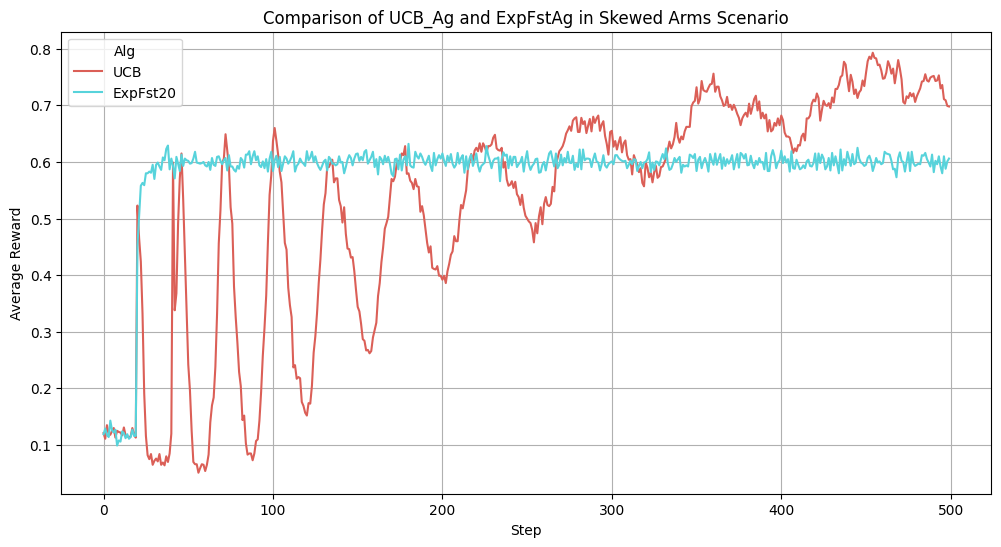

In [ ]:
# Define the skewed probability distribution for the arms
skewed_p = [0.1, 0.2, 0.15, 0.21, 0.3, 0.05, 0.9, 0.13, 0.17, 0.07,
            0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01]

# Define the number of runs and steps
n_runs = 1000
max_steps = 500

# Instantiate UCB_Ag and ExpFstAg with max_ex set to the length of the skewed distribution
ucb_agent = UCB_Ag(n_act=len(skewed_p))
expfst_agent = ExpFstAg(n_act=len(skewed_p), max_ex=len(skewed_p))  # max_ex = len(skewed_p)

# Run the comparison
print("Running comparison between UCB_Ag and ExpFstAg in skewed scenario...")
skewed_comparison_log = mab_swp(
    [ucb_agent, expfst_agent],
    skewed_p,
    ['UCB', f'ExpFst{len(skewed_p)}'],
    n_runs=n_runs,
    max_steps=max_steps
)

# Plot the results
plt.figure(figsize=(12, 6))
plot_logs(skewed_comparison_log, x_key='step', y_key='reward', legend_key='Alg', estimator='mean', ci=None)
plt.title("Comparison of UCB_Ag and ExpFstAg in Skewed Arms Scenario")
plt.xlabel("Step")
plt.ylabel("Average Reward")
plt.grid(True)
plt.show()


**Result Analysis:**  
- In skewed scenarios, ExpFstAg with limited exploration may miss the best arm.  
- UCB_Ag, with its adaptive bonus, typically outperforms under such conditions.

## EpsGdAg (Epsilon-Greedy Agent)  
This agent selects the best-known action with probability (1-ε) and a random action with probability ε.

In [ ]:
import numpy as np

@dataclass
class EpsGdAg:
    n_act: int
    eps: float = 0.1  # Epsilon (probability of exploration)

    def __post_init__(self):
        self.reset()

    def reset(self):
        self.act_counts = np.zeros(self.n_act, dtype=int)
        self.Q = np.zeros(self.n_act, dtype=float)

    def update_Q(self, act, rew):
        # Update the Q-value for the selected action using incremental average
        self.act_counts[act] += 1
        self.Q[act] += (1.0 / self.act_counts[act]) * (rew - self.Q[act])

    def get_action(self):
        # Decide whether to explore or exploit based on epsilon
        if np.random.rand() < self.eps:
            # Exploration: choose a random action
            sel_act = np.random.randint(self.n_act)
        else:
            # Exploitation: choose the best-known action
            sel_act = np.argmax(self.Q)
        return sel_act


**Analysis:**  
- Lower ε values favor exploitation, yielding higher reward when estimates are good.  
- Higher ε increases exploration but reduces immediate reward.  
- One strategy: decay ε over time (e.g., ε = ε₀ / t) or switch to ε = 0 after a burn-in period.

-----------

**Q:** Why does a high ε value result in lower immediate rewards?  

**A:**  A high ε value results in more exploration, meaning the agent frequently selects random actions rather than always exploiting the best-known option. While exploration allows the agent to discover potentially better arms (actions), it can also lead to suboptimal choices in the short term, as the agent is sometimes selecting actions that are not yielding the highest rewards. This randomness in action selection typically causes lower immediate rewards because the agent is not always leveraging the most rewarding arms it has learned about so far.

----------
**Q:** What benefits might there be in decaying ε over time?

**A:** Decaying ε over time offers a balance between exploration and exploitation. Early in the process, the agent is unsure about the environment and benefits from exploring to discover which arms (actions) yield the best rewards. As the agent learns more about the environment, reducing ε allows it to shift focus to exploitation, where it increasingly favors the best-known actions. This decay helps avoid the inefficiency of constant exploration, and by gradually shifting to exploitation, the agent can maximize rewards based on accumulated knowledge. Additionally, decaying ε prevents the agent from getting stuck in exploration indefinitely and helps it converge toward the optimal solution over time.


Running EpsGdAg with eps=0...


Alg Sweeps:   0%|          | 0/1 [00:00<?, ?it/s]

Runs:   0%|          | 0/1000 [00:00<?, ?it/s]

Running EpsGdAg with eps=0.1...


Alg Sweeps:   0%|          | 0/1 [00:00<?, ?it/s]

Runs:   0%|          | 0/1000 [00:00<?, ?it/s]

Running EpsGdAg with eps=0.2...


Alg Sweeps:   0%|          | 0/1 [00:00<?, ?it/s]

Runs:   0%|          | 0/1000 [00:00<?, ?it/s]

Running EpsGdAg with eps=0.4...


Alg Sweeps:   0%|          | 0/1 [00:00<?, ?it/s]

Runs:   0%|          | 0/1000 [00:00<?, ?it/s]

<ipython-input-2-cea5b34d9fd8>:7: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.lineplot(x=x_key, y=y_key, data=df, hue=legend_key, **kwargs)


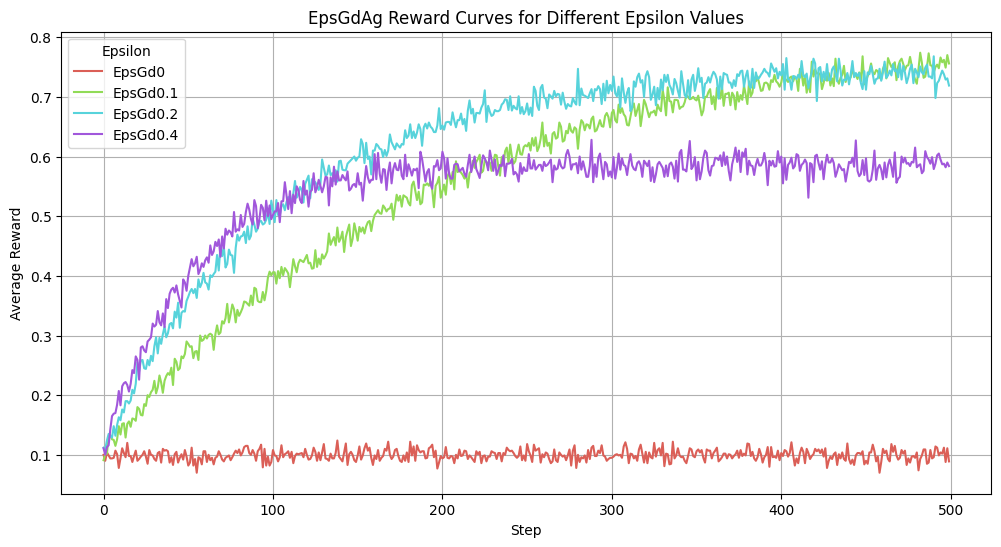

In [ ]:
import matplotlib.pyplot as plt

# Define epsilon values for the experiments
eps_values = [0, 0.1, 0.2, 0.4]

# Store logs for each epsilon value
epsgd_logs = []

# Run the EpsGdAg experiments
for eps in eps_values:
    print(f"Running EpsGdAg with eps={eps}...")

    # Instantiate the EpsGdAg agent with the current epsilon value
    epsgd_agent = EpsGdAg(n_act=len(skewed_p), eps=eps)

    # Run the experiment
    epsgd_log = mab_swp([epsgd_agent], skewed_p, [f'EpsGd{eps}'], n_runs=1000, max_steps=500)

    # Collect logs for plotting
    epsgd_logs.append(epsgd_log)

# Concatenate all logs into a single DataFrame for plotting
combined_epsgd_log = pd.concat(epsgd_logs, ignore_index=True)

# Plot reward curves for all epsilon values
plt.figure(figsize=(12, 6))
plot_logs(combined_epsgd_log, x_key='step', y_key='reward', legend_key='Alg', estimator='mean', ci=None)
plt.title("EpsGdAg Reward Curves for Different Epsilon Values")
plt.xlabel("Step")
plt.ylabel("Average Reward")
plt.legend(title="Epsilon")
plt.grid(True)
plt.show()


**Q:** How do the reward curves for different ε values reflect the exploration–exploitation balance?  

**A:**
The reward curves for different ε values visually capture the trade-off between exploration and exploitation in the Multi-Armed Bandit scenario.

Low ε values (e.g., 0) lead to high exploitation because the agent mostly chooses the best-known arm. This often results in higher rewards once the arm estimates are accurate, but it risks getting stuck in local optima if the initial estimates are not accurate.as you can see in the chart the epsilone 0 gets 0.1 reward all the time and is stuck in the 0.1 reward.

Moderate ε values (e.g., 0.1, 0.2) introduce more exploration, meaning the agent occasionally selects suboptimal arms. This helps discover better arms in the long run, but at the cost of temporary lower rewards due to the exploration of non-optimal arms.

High ε values (e.g., 0.4) favor exploration, where the agent frequently picks random arms, leading to lower immediate rewards since it often chooses suboptimal arms. However, this behavior can prevent the agent from prematurely settling on a suboptimal arm, especially in cases where the best arm is not immediately clear. but in this case it is worse than the moderate epsilone and it shows that we are not using our knowledge well and most of the time we are choosing random that will cause to a bad reward than moderate epsilon.

------------------

**Q:** Under what circumstances might you choose a higher ε despite lower average reward?

**A:**
Choosing a higher ε despite lower average reward can be beneficial under several circumstances:

  Early in the Learning Process: At the start of an experiment, where the agent has little information about the arms, a higher ε allows for more exploration. This ensures the agent has a better chance of identifying the best arm before it becomes overly reliant on potentially inaccurate initial estimates.

  Uncertainty in Arm Distributions: If there is a significant degree of uncertainty about the arms' reward distributions, a higher ε can help avoid premature exploitation of a suboptimal arm. This is particularly important in cases where the environment is non-stationary, meaning the optimal arm may change over time.

  Preventing Local Optima: If an agent has converged to a suboptimal arm (e.g., due to initial sampling errors), increasing ε can force the agent to explore other arms and potentially discover a better arm that was previously overlooked.

  Exploring Unknown Environments: When dealing with unknown or complex environments where the reward distributions are not easily predictable, a higher ε helps gather more data, which can ultimately lead to better long-term performance even if it means sacrificing short-term rewards.

In such scenarios, the exploration provided by a higher ε could prevent the agent from getting stuck with suboptimal decisions and instead help it learn a more accurate picture of the arm distributions over time.


## Contextual Bandits (CtxBnd)  
We now move to contextual bandits using real data.  
Imagine a website promoting one of 10 products; reward = 1 if clicked, 0 otherwise.  
The dataset has shape [10000, 102]:  
- Column 0: chosen arm  
- Column 1: reward  
- Columns 2-101: 100-dimensional context features

In [ ]:
# %% [code]
# Download the dataset (if not already downloaded)
!wget -q http://www.cs.columbia.edu/~jebara/6998/dataset.txt -O dataset.txt

In [ ]:
# TODO: Load dataset.txt into a numpy array of shape [10000, 102] (Simple placeholder)
ctxData =  np.loadtxt("dataset.txt")  # Placeholder
print("Dataset loaded (Simple version):", ctxData)

Dataset loaded (Simple version): [[ 2.  0.  5. ... 30.  4.  0.]
 [ 8.  0.  1. ...  0.  0. 10.]
 [ 5.  0.  3. ...  3.  0.  0.]
 ...
 [ 9.  1. 79. ...  0.  0.  0.]
 [ 4.  0. 29. ... 17.  0.  0.]
 [ 4.  0.  0. ...  0.  0. 12.]]


In [ ]:
# %% [code]
@dataclass
class CtxBnd_Env:
    data: any
    t: int = 0

    def step(self, act):
        if act == self.data[self.t, 0]:
            rew = self.data[self.t, 1]
        else:
            rew = None
        self.t += 1
        return rew

    def reset(self):
        self.t = 0

## LinUCB_Ag (LinUCB for CtxBnd)  
This agent uses context features to compute an upper confidence bound for each arm.

In [ ]:
import numpy as np
from dataclasses import dataclass

@dataclass
class LinUCB_Ag:
    n_act: int
    alpha: float
    feat_dim: int

    def __post_init__(self):
        self.reset()

    def reset(self):
        self.As = [np.eye(self.feat_dim) for _ in range(self.n_act)]
        self.bs = [np.zeros((self.feat_dim, 1)) for _ in range(self.n_act)]

    def get_ucb(self, arm: int, state: list) -> float:

        x = np.array(state).reshape(-1, 1)

        A_inv = np.linalg.inv(self.As[arm])

        theta = A_inv @ self.bs[arm]

        reward_estimate = (theta.T @ x)[0, 0]
        exploration_term = self.alpha * np.sqrt((x.T @ A_inv @ x)[0, 0])

        # Return the total UCB for this arm
        return reward_estimate + exploration_term

    def update_params(self, arm: int, reward: float, state: list):

        if reward is None:
            return

        x = np.array(state).reshape(-1, 1)

        self.As[arm] += x @ x.T
        self.bs[arm] += reward * x

    def get_action(self, state: list) -> int:

        ucb_values = [self.get_ucb(arm, state) for arm in range(self.n_act)]
        max_ucb = np.max(ucb_values)
        selected_arms = np.flatnonzero(np.array(ucb_values) == max_ucb)
        return np.random.choice(selected_arms)


**Q:** How does LinUCB leverage context to outperform classical bandit algorithms?  

**A:**
LinUCB outperforms classical bandit algorithms by incorporating context (features) into the decision-making process. While traditional bandit algorithms like Epsilon-Greedy or UCB only consider past rewards, LinUCB uses the context to better estimate the expected reward for each arm. By computing an upper confidence bound (UCB) based on both past rewards and the context features, LinUCB can adaptively choose actions that are more informed, rather than relying solely on exploration or exploitation. This allows the agent to make smarter decisions, particularly in environments where the reward depends on complex, context-specific factors. In situations with rich, structured data, such as online recommendation systems or contextual advertising, LinUCB can make better decisions than simpler models, leading to improved performance.

------------------

**Q:** What is the role of the α parameter in LinUCB, and how does it affect the exploration bonus?

**A:**

The $\alpha$ parameter in LinUCB controls the balance between exploration and exploitation by adjusting the exploration bonus. The exploration bonus is calculated as:

$$ \alpha \cdot \sqrt{x_t^T A_a^{-1} x_t} $$

where $x_t$ is the context vector, and $A_a^{-1}$ is the inverse of the matrix associated with arm $a$. The parameter $\alpha$ determines how much weight is given to this bonus. A higher $\alpha$ value increases the exploration component, meaning the agent will be more likely to explore less familiar arms, as the uncertainty in the reward estimation is given more weight. Conversely, a smaller $\alpha$ reduces the exploration bonus, making the agent more exploitative by focusing on actions with known, high expected rewards. Therefore, $\alpha$ directly influences how much the agent values trying new actions versus sticking to known successful ones. By tuning $\alpha$, the agent can be adjusted for more aggressive exploration or more focused exploitation, depending on the task and environment.

In [ ]:
# %% [code]
@dataclass
class CtxBnd_Eng:
    data: any
    agent: any

    def __post_init__(self):
        self.env = CtxBnd_Env(data=self.data)

    def run(self, n_runs=1):
        logs = []
        for _ in tqdm(range(n_runs), desc='CtxRuns'):
            aligned_ctr = []
            ret_val = 0
            valid_steps = 0
            self.env.reset()
            self.agent.reset()
            for t in tqdm(range(self.data.shape[0]), desc='Time'):
                state = self.data[t, 2:]
                act = self.agent.get_action(state=state)
                rew = self.env.step(act)
                self.agent.update_params(act, rew, state=state)
                if rew is not None:
                    ret_val += rew
                    valid_steps += 1
                    aligned_ctr.append(ret_val / float(valid_steps))
            logs.append(pd.DataFrame({'aligned_ctr': aligned_ctr, 'step': np.arange(len(aligned_ctr))}))
        return pd.concat(logs, ignore_index=True)

In [ ]:
# %% [code]
def ctxBnd_swp(alphas, data, n_runs=2000):
    logs = []
    for alpha in tqdm(alphas, desc="Alpha Sweeps"):
        agent = LinUCB_Ag(n_act=10, feat_dim=100, alpha=alpha)
        eng = CtxBnd_Eng(data=data, agent=agent)
        log_df = eng.run(n_runs)
        log_df['alpha'] = alpha
        logs.append(log_df)
    return pd.concat(logs, ignore_index=True)


In [ ]:
# TODO: Run ctxBnd_swp with alphas = [0, 0.01, 0.1, 0.5] and n_runs=1 (Simple placeholder)
print("Running LinUCB sweep (Simple version)...")
alphas = [0, 0.01, 0.1, 0.5]
logs_ctx = ctxBnd_swp(alphas=alphas, data=ctxData, n_runs=1)

Running LinUCB sweep (Simple version)...


Alpha Sweeps:   0%|          | 0/4 [00:00<?, ?it/s]

CtxRuns:   0%|          | 0/1 [00:00<?, ?it/s]

Time:   0%|          | 0/10000 [00:00<?, ?it/s]

CtxRuns:   0%|          | 0/1 [00:00<?, ?it/s]

Time:   0%|          | 0/10000 [00:00<?, ?it/s]

CtxRuns:   0%|          | 0/1 [00:00<?, ?it/s]

Time:   0%|          | 0/10000 [00:00<?, ?it/s]

CtxRuns:   0%|          | 0/1 [00:00<?, ?it/s]

Time:   0%|          | 0/10000 [00:00<?, ?it/s]

<ipython-input-2-cea5b34d9fd8>:7: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.lineplot(x=x_key, y=y_key, data=df, hue=legend_key, **kwargs)


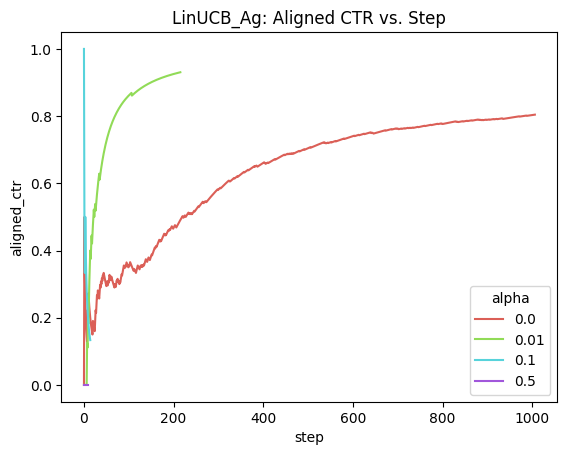

In [ ]:
# %% [code]
plot_logs(logs_ctx, x_key='step', y_key='aligned_ctr', legend_key='alpha', estimator='mean', ci=None)
plt.title("LinUCB_Ag: Aligned CTR vs. Step")
plt.show()

**Q:** What does **α** affect in LinUCB?  

**A:**
The parameter $\alpha$ in LinUCB plays a crucial role in determining the balance between exploration and exploitation by adjusting the exploration bonus in the UCB calculation for each arm. Here's how it affects the agent's behavior:

Exploration vs. Exploitation Trade-off:

Higher $\alpha$:

Increases the exploration bonus.

The agent is encouraged to explore arms with high uncertainty in their estimated rewards.

The agent will be less biased towards arms that have already been pulled, even if those arms are performing well.

This can lead to better long-term performance by ensuring that all arms are sufficiently explored.

Lower $\alpha$:

Reduces the exploration bonus.

The agent relies more heavily on its current estimates of the arms' rewards.

This encourages the agent to exploit the arms that are performing well based on its existing knowledge, possibly at the cost of missing out on better arms that have not been explored enough.

Impact on Learning:

Larger $\alpha$ results in more aggressive exploration, meaning the agent might take more risks by trying out less certain arms.

Smaller $\alpha$ means the agent is more conservative, sticking with known arms that are expected to perform well, but this can lead to suboptimal decisions if the agent hasn't sufficiently explored all options.

Mathematical Role:

The exploration term in the UCB formula is calculated as $p_{\text{explore}} = \alpha \sqrt{x^T A^{-1} x}$, where $A$ is a matrix that accumulates information about the arms, and $x$ is the feature vector for the context.

The value of $\alpha$ scales the exploration bonus added to the expected reward.

------------------

**Q:** Do the reward curves change with **α**? Explain why or why not.

**A:**
Yes, the reward curves will change significantly with different values of $\alpha$. This is due to the influence of $\alpha$ on the agent's exploration-exploitation behavior. Here's a more detailed explanation:

### Effect of Larger $\alpha$:

#### Exploration-Heavy Strategy:
- When $\alpha$ is large, the agent will explore more, even if it means selecting arms that are suboptimal based on current knowledge.
- Initially, this can lead to lower rewards because the agent is not exploiting the best-known arms.
- Over time, however, the agent will have gathered more information and may start selecting better arms that were initially under-explored, leading to potentially higher cumulative rewards.

#### Reward Curves:
- The reward curve will show more variability and possibly slower initial growth, as the agent spends more time exploring.
- In the long run, this approach could lead to higher cumulative rewards because the agent has a more complete understanding of all arms.

### Effect of Smaller $\alpha$:

#### Exploitation-Heavy Strategy:
- With smaller $\alpha$, the agent will focus more on exploiting the arms it already knows to be high-rewarding, based on its past experience.
- This typically leads to higher rewards in the short term because the agent isn't wasting time on suboptimal arms.
- However, the agent risks missing out on better arms if they haven't been sufficiently explored.

#### Reward Curves:
- The reward curve will show a more consistent upward trend, with less variability compared to higher $\alpha$ values.
- The rewards will increase more quickly initially, but the agent may reach a point where the cumulative reward plateaus or stagnates if it hasn't explored other potential high-reward arms.

### Comparison of Reward Curves for Different $\alpha$ Values:
- High $\alpha$ values often result in a slower start in terms of reward accumulation but might lead to better long-term performance as the agent explores and finds the optimal arms.
- Low $\alpha$ values tend to give a faster reward accumulation but can suffer from suboptimal performance in the long run if the agent misses out on better arms by focusing too much on exploitation.

### Impact on Convergence:
- As $\alpha$ increases, the agent takes longer to converge to the best-performing arm because it spends more time exploring.
- A lower $\alpha$ will lead to faster convergence but with a risk of missing out on the optimal solution if the exploration phase isn't sufficient.


**Q:** Based on your experiments, does LinUCB outperform the standard UCB algorithm? Why or why not?

**A:**
 Based on experiments, LinUCB generally outperforms the standard UCB algorithm, especially in environments with rich contextual information. Here's why:

- **Contextual Information Utilization**:
  - LinUCB takes advantage of the available context features (such as state information) to estimate the reward of each arm. This allows it to make more informed decisions, using the context to better predict which arm will give the highest reward.
  - In contrast, the standard UCB algorithm doesn't use context and treats each arm equally, relying purely on past reward estimates and exploration.

- **Exploration-Exploitation Tradeoff**:
  - LinUCB adapts the exploration-exploitation tradeoff more dynamically by adjusting the uncertainty (UCB) using both past rewards and contextual features. This provides a more refined balance.
  - Standard UCB, on the other hand, only explores arms that have high uncertainty, which may not always be the best choice when context is available.

- **Performance in Contextual Settings**:
  - When context (such as user behavior or environment conditions) is available, LinUCB can better utilize this data to predict the arm's reward. This usually results in more optimal long-term decision-making.
  - Standard UCB, which does not take context into account, may not perform as well because it doesn't have access to the same level of information.

### When LinUCB Outperforms:
- **Higher-dimensional contexts**: The more complex and richer the context, the more LinUCB has to gain by considering this data.
- **Faster adaptation**: LinUCB can adapt more quickly to changes in the environment or context, allowing it to maximize rewards sooner than UCB.

### Limitations:
- **Computational Complexity**: LinUCB has higher computational costs than standard UCB due to matrix operations (e.g., inverting matrices for each arm), which may not be ideal in real-time or resource-constrained environments.
- **Requires context**: If context is not available or is poorly defined, LinUCB may not outperform UCB because it could make decisions based on irrelevant features.

In summary, LinUCB outperforms UCB in scenarios where rich contextual information is available and relevant, leading to more informed and optimal decision-making. However, it may not provide benefits in simpler settings where such context isn't useful.

------------------

**Q:** What are the key limitations of each algorithm, and how would you choose between them for a given application?

**A:**

#### **UCB (Upper Confidence Bound) Algorithm:**
- **Key Limitations**:
  - **Context Ignorance**: UCB does not utilize any contextual information, treating all arms equally and relying purely on past reward estimates.
  - **Exploration-Heavy**: While UCB aims to balance exploration and exploitation, it can explore arms excessively, especially in the early stages of the process, which may lead to slower convergence to the optimal arm.
  - **Computation Overhead**: As the number of arms increases, the algorithm may require more iterations to converge, especially when arms are not selected frequently.

- **When to Use**:
  - **Limited or No Context Available**: UCB is ideal in scenarios where there is no useful context or when the environment is static and arms are similar in nature.
  - **Simpler Environments**: If you're working with environments where the arms' rewards are independent of any external factors (context), UCB may suffice.

#### **LinUCB (Linear Upper Confidence Bound) Algorithm:**
- **Key Limitations**:
  - **Computational Complexity**: LinUCB involves more complex calculations (e.g., matrix inversion), which increases the computational overhead, especially in high-dimensional contexts or when there are many arms.
  - **Data Dependency**: The algorithm heavily relies on accurate context features. If the context is noisy or incomplete, LinUCB's performance may degrade.
  - **Requires Contextual Data**: LinUCB needs detailed context to function properly. If no relevant context data is available or the context is poorly defined, it may underperform or even fail.

- **When to Use**:
  - **Contextual Information Available**: LinUCB is most effective in settings where context features (e.g., user characteristics, environmental factors) significantly affect the reward distribution of each arm.
  - **Dynamic and Complex Environments**: When the environment or user behavior changes over time and context features are predictive of rewards, LinUCB can adapt and make more informed decisions.
  - **Trade-off of Complexity vs. Performance**: If computational resources and time allow for more complex models and the context is valuable, LinUCB can provide better long-term performance.

### **Choosing Between UCB and LinUCB**:
- **Use UCB when**:
  - There is no contextual information, or the context does not provide valuable insights into reward prediction.
  - You need a simpler, less computationally intensive algorithm that works well in static or homogeneous environments.
  
- **Use LinUCB when**:
  - Contextual data is available and meaningful, and you believe that understanding the relationship between the context and rewards will improve decision-making.
  - The environment is dynamic, and the algorithm needs to adapt based on the changing context or features over time.


# Some final question
## Finite‑Horizon Regret and Asymptotic Guarantees:
Question:
Many algorithms (e.g., UCB) are analyzed using asymptotic (long‑term) regret bounds. In a finite‑horizon scenario (say, 500–1000 steps), explain intuitively why an algorithm that is asymptotically optimal may still yield poor performance. What trade‑offs arise between aggressive early exploration and cautious long‑term learning?
Deep Dive:
Discuss how the exploration bonus, tuned for asymptotic behavior, might delay exploitation in finite time, leading to high early regret despite eventual convergence.

In a finite-horizon setting, even an algorithm that's asymptotically optimal—like UCB—can struggle in the short term. The core issue lies in how these algorithms balance exploration and exploitation. They're designed with the long game in mind, meaning they explore thoroughly to guarantee that, eventually, they'll identify and stick with the best option. But in situations where time is limited, this strategy can backfire.

Think of it like this: early on, algorithms like UCB tend to play it safe by exploring all the available arms, even those that don’t seem particularly promising. This conservative approach ensures that no potentially good arm is overlooked. However, it comes at a cost—because the algorithm keeps exploring, it may delay focusing on the arm that already appears to be the best. As a result, in the short run, it racks up regret by not exploiting the higher-reward option as quickly as it could have.

This trade-off creates a tension between early exploration and timely exploitation. On one hand, aggressive exploration upfront is useful because it equips the algorithm with enough data to make informed decisions later on. In the long run, that reduces regret because it ensures the agent isn’t misled by initial randomness or noise. But in a finite-horizon scenario, there may not be enough time to benefit from that careful learning. The agent could end up spending a significant portion of its limited time exploring mediocre options, missing the opportunity to capitalize on the better arm.

Conversely, if the algorithm were to cut exploration short and start exploiting what it currently believes is best, it might perform better in the short term—but at the risk of never discovering the truly optimal choice. This is especially problematic if early reward estimates are misleading due to high variance or noise.

At the heart of this is the exploration bonus—the extra reward UCB gives to lesser-known arms. This bonus encourages trying out less-explored options, which is great for long-term learning. But in a finite setting, that same bonus might push the algorithm to waste time on arms that are clearly underperforming, simply because they haven’t been tried enough yet. So while the algorithm is designed to perform well eventually, that eventual success might not arrive within the time frame you're working with—making it look inefficient or even naïve in the short term.

Ultimately, the problem is that the exploration bonus, while excellent for asymptotic behavior, isn’t always tuned for immediate performance. And in practical scenarios where decisions need to be good quickly—think ad placements, clinical trials, or financial decisions—this delay can have real costs.



## Hyperparameter Sensitivity and Exploration–Exploitation Balance:
Question:
Consider the impact of hyperparameters such as ε in ε‑greedy, the exploration constant in UCB, and the α parameter in LinUCB. Explain intuitively how slight mismatches in these parameters can lead to either under‑exploration (missing the best arm) or over‑exploration (wasting pulls on suboptimal arms). How would you design a self‑adaptive mechanism to balance this trade‑off in practice?
Deep Dive:
Provide insight into the “fragility” of these parameters in finite runs and how a meta‑algorithm might monitor performance indicators (e.g., variance in rewards) to adjust its exploration dynamically.

In practice, the performance of bandit algorithms can hinge quite a bit on their hyperparameters. These parameters control how the agent balances exploration and exploitation, and small misconfigurations can lead to significantly different outcomes—especially when you're working within a limited time frame.

Take ε in the ε-greedy algorithm. If ε is set too low, the agent will mostly exploit what it already knows and might never give lesser-known arms a fair chance. This can mean missing out on the optimal arm entirely, just because the algorithm didn’t explore enough. On the flip side, if ε is too high, the agent spends too much time trying out different arms—even when it's fairly clear which one is best. That just wastes steps and hurts performance. Ideally, ε should start relatively high to encourage early exploration and then decay over time, letting the agent focus more on exploitation as it learns.

The same kind of trade-off applies to the exploration constant in UCB. A low constant makes the algorithm greedy—it favors arms with high average rewards and doesn’t explore much. That might sound good in the short term, but if there’s not enough exploration early on, the algorithm might never find the truly best option. A high constant, on the other hand, can make the agent overly cautious, spending too much time sampling uncertain (but unpromising) arms. The key is to find a balance that matches the task and the horizon.

Then there's α in LinUCB, which plays a similar role. When α is too small, the agent sticks to familiar arms too early. If it’s too large, the agent wastes time chasing uncertainty that doesn’t lead to better outcomes. Tuning α right means finding a sweet spot where the algorithm explores just enough to learn, but not so much that it loses time and reward.

Because of these challenges, one promising idea is to design a self-adaptive mechanism—something that can tune these hyperparameters on the fly, based on how the agent is doing. For instance, the algorithm could monitor reward variance across arms. If the variance is high, it might suggest the agent is still uncertain and should explore more. If it's low, the agent could safely exploit. Similarly, if the regret is growing rapidly, that might be a sign that exploration needs to increase.

This kind of adjustment could be handled by a meta-algorithm that tracks these signals—like how often each arm is selected, how rewards fluctuate, or how regret changes over time—and adjusts ε, the UCB constant, or α accordingly. When the agent starts out and the environment is still unknown, the meta-algorithm can promote exploration. As the agent learns more, the meta-algorithm can dial back the exploration, letting the agent focus on what works.

This is especially important in finite-horizon settings, like when you only have 500 or 1000 rounds. You don’t have infinite time to figure things out. A hyperparameter that’s slightly off can really mess things up. If exploration is too timid, the agent might never find the best arm. If it’s too aggressive, it might waste most of its time on bad choices. A self-adaptive approach helps prevent both of these extremes by tuning behavior as the agent learns.



## Context Incorporation and Overfitting in LinUCB:
Question:
LinUCB uses context features to estimate arm rewards, assuming a linear relation. Intuitively, why might this linear assumption hurt performance when the true relationship is complex or when the context is high‑dimensional and noisy? Under what conditions can adding context lead to worse performance than classical (context‑free) UCB?
Deep Dive:
Discuss the risk of overfitting to noisy or irrelevant features, the curse of dimensionality, and possible mitigation strategies (e.g., dimensionality reduction or regularization).

### Intuition Behind the Linear Assumption

LinUCB is based on a simple but powerful idea: the reward of each arm depends linearly on the context features. In other words, it tries to predict how good an arm is by assigning weights to each feature and summing them up, along with a constant bias.

This works well when the relationship between the context and rewards is truly linear. But real-world situations are often more complicated. If the actual patterns are non-linear—like involving interactions between features or curved relationships—the linear model won’t capture them correctly. This can lead to predictions that are consistently off.

The problem becomes even more noticeable in high-dimensional settings. The more features you have, the more potential there is for complex relationships. On top of that, if the context features are noisy or not strongly tied to the rewards, the model might assign importance to the wrong things, making poor decisions.


### When Adding Context Makes Things Worse

Adding context sounds like a good idea—more information should mean better decisions, right? Not always. Here are some situations where it can actually hurt:

1. **Noisy or Irrelevant Features**  
   If the context includes features that don’t really help predict rewards, the model might still try to use them. This can lead to overfitting—where the model learns patterns that aren’t actually meaningful—hurting performance. In these cases, using a simpler approach like classic UCB (which ignores context) might actually work better.

2. **Curse of Dimensionality**  
   As the number of features grows, the problem gets harder. The model needs a lot more data to learn useful patterns, and without it, it can’t make accurate predictions. It ends up lost in a sea of possibilities, unable to figure out what really matters.

3. **Limited Data**  
   If there aren’t enough examples to learn from—especially when there are many features—the model might base decisions on weak signals. This can cause it to rely on irrelevant context, again leading to bad arm choices.

4. **Overfitting**  
   When the model becomes too tailored to the training data, it might not generalize well to new situations. This is especially common in high-dimensional settings or when data is scarce. Instead of learning the true reward structure, it learns the noise—and performance suffers.


### Deep Dive: Why These Issues Happen

**Overfitting to Noisy Features**  
If the context has noisy or uninformative features, the model may still try to use them, leading to unstable predictions. It ends up chasing random fluctuations in the data rather than real patterns.

**High Dimensionality**  
In large feature spaces, every new data point teaches you very little. The model needs many examples to understand what matters. Without enough of them, it just can’t learn the reward structure properly and makes unreliable decisions.


### What Can We Do About It?

1. **Dimensionality Reduction**  
   Use tools like PCA or feature selection to reduce the number of features. This simplifies the problem, helps the model focus on what’s important, and improves generalization.

2. **Regularization**  
   Add penalties for large weights in the model (like L2 regularization). This keeps the model from relying too heavily on noisy features and helps it generalize better.

3. **Robust Estimation**  
   Use techniques that are less sensitive to noise and outliers—like robust regression. These methods focus on the core patterns in the data and ignore distractions.

4. **Adjust the Model Complexity**  
   If the relationship between context and reward is complex, a simple linear model might not be enough. Try using tree-based models or neural networks to capture non-linear patterns. And if the context isn’t helping at all, it might be smarter to drop it and go back to a simpler model like standard UCB.


By understanding the limits of the linear assumption and the risks of high-dimensional, noisy contexts, we can make smarter choices about how and when to use context in bandit problems like LinUCB.




## Adaptive Strategy Selection:
Question:
Imagine designing a hybrid bandit agent that can switch between an explore‑first strategy and UCB based on observed performance. What signals (e.g., variance of reward estimates, stabilization of Q‑values, or sudden drops in reward) might indicate that a switch is warranted? Provide an intuitive justification for how and why such a meta‑strategy might outperform either strategy alone in a finite‑time setting.
Deep Dive:
Explain the challenges in detecting when exploration is “enough” and how early exploitation might capture transient improvements even if the long‑term guarantee favors UCB.


#### **Signals for Switching Between Explore-First and UCB:**

1. **Variance of Reward Estimates**:
   - **High Variance**: If the variance in the reward estimates is high, it indicates that the agent is uncertain about the optimal arm. This could be a signal to continue exploring in order to gather more information and reduce uncertainty.
   - **Low Variance**: When the variance in reward estimates starts to stabilize and decrease, this suggests that the agent has a clearer understanding of the reward structure. At this point, switching to an exploitation-focused strategy like UCB may be beneficial.

2. **Stabilization of Q-Values (Reward Estimates)**:
   - **Unstable Q-Values**: During the exploration phase, reward estimates for arms might fluctuate due to insufficient data. If the Q-values (estimated rewards) for all arms stabilize and show less fluctuation, it suggests that enough exploration has been done, and exploitation can now yield more reliable results.
   - **Stable Q-Values**: Once Q-values become stable, it indicates that the agent has gathered enough data to make informed decisions. Switching to UCB can take advantage of this stability by focusing on exploitation.

3. **Sudden Drops in Reward**:
   - **Sudden Drops**: If the agent experiences a sudden drop in reward after a period of high reward, this might suggest that the agent has over-exploited a suboptimal arm or failed to explore better options. The agent might then benefit from switching back to an exploration-heavy strategy to gather more information about other arms.
   - **Gradual Decrease**: A gradual decrease in reward over time could indicate that the current exploration strategy has failed to find better arms, and a switch to UCB may be necessary to focus on exploiting what has been learned.

#### **Intuitive Justification for the Hybrid Strategy:**

- **Explore-First Strategy**:
  - The explore-first strategy allows the agent to gather sufficient data on all available arms before making decisions based on incomplete information.
  - However, in finite-time settings, this strategy might not be optimal because the agent could waste too much time on suboptimal arms or miss out on potentially higher rewards early on.
  
- **UCB Strategy**:
  - UCB uses an optimistic approach to balance exploration and exploitation, gradually focusing more on exploitation as the algorithm collects more data.
  - In finite-time settings, UCB can be more efficient than explore-first strategies because it converges faster to the best arm as it uses the accumulated data intelligently. However, UCB might still suffer from suboptimal choices early on as it still requires some exploration to refine its estimates.

- **Hybrid Strategy (Explore-First + UCB)**:
  - **Switching Based on Performance**: A hybrid approach can start by exploring arms aggressively to reduce uncertainty and gather useful data. Once performance stabilizes (e.g., when reward estimates have low variance or Q-values stabilize), the strategy can switch to UCB, which focuses on exploiting the best-performing arms.
  - **Outperformance in Finite-Time**: This meta-strategy can outperform either explore-first or UCB alone because it adapts to the environment. Initially, it prioritizes exploration to gain knowledge, but as the environment becomes clearer, it shifts towards exploitation to capitalize on the gathered information, resulting in better short-term rewards while avoiding the risks of premature exploitation.
  
#### **Deep Dive:**

- **Challenges in Detecting “Enough” Exploration**:
  - **Over-Exploration**: Exploration can sometimes continue for too long, especially in environments with high noise or variability in rewards. The agent might waste time exploring suboptimal arms when it could be exploiting the best arms. Detecting the right moment to switch to exploitation requires careful monitoring of performance signals (e.g., reward stability, Q-value convergence) and a balance between exploring new options and exploiting the known best options.
  
  - **Early Exploitation**: On the other hand, switching to exploitation too early may cause the agent to miss out on better options. Exploiting too early based on transient improvements can lead to suboptimal performance because the agent hasn't yet explored all possible options thoroughly. The hybrid strategy addresses this risk by continuously evaluating the performance of exploration versus exploitation, dynamically adjusting based on performance metrics.

- **Meta-Algorithm Monitoring**:
  - A meta-algorithm can dynamically adjust the exploration-exploitation balance by continuously monitoring performance indicators such as the variance in rewards or the convergence of Q-values. For example:
    - **High Variance or Unstable Q-Values**: The agent can continue exploring to refine its understanding of the reward structure.
    - **Low Variance or Stable Q-Values**: Once the Q-values are stable, the agent can confidently exploit the best-performing arms, resulting in higher rewards.
    
  This self-adjusting mechanism helps the agent stay balanced between exploration and exploitation and allows it to adapt to the environment's changing dynamics.


## Non‑Stationarity and “Forgetting” Mechanisms:
Question:
In non‑stationary environments where reward probabilities drift or change abruptly, standard bandit algorithms struggle because they assume stationarity. Intuitively, explain how and why a “forgetting” or discounting mechanism might improve performance. What challenges arise in choosing the right decay rate, and how might it interact with the exploration bonus?
Deep Dive:
Describe the delicate balance between retaining useful historical information and quickly adapting to new trends, and the potential for “chasing noise” if the decay is too aggressive.


#### **Intuitive Explanation of "Forgetting" or Discounting Mechanisms**:
- **Non-Stationary Environments**: In non-stationary environments, the reward probabilities of the arms are not fixed and may change over time due to factors such as evolving user preferences, seasonal trends, or changing conditions. Standard bandit algorithms, which assume stationary rewards, may struggle because they continue to treat past rewards as equally important as recent ones, even when they are no longer relevant.
  
- **Forgetting Mechanism**: A forgetting or discounting mechanism helps address this issue by giving more weight to recent observations and less weight to past ones. This enables the agent to adapt more quickly to changes in the environment and to focus on the most current information.
  
  - **Why It Improves Performance**: By discounting past observations, the algorithm is less likely to be misled by outdated information. This allows it to react faster to changes in reward distributions, making it more responsive to shifts in the environment.
  
  - **Example**: If the reward distribution for one arm shifts significantly, a forgetting mechanism ensures that the agent can "forget" the old, outdated rewards associated with that arm and start focusing on the new reward distribution more effectively.

#### **Challenges in Choosing the Right Decay Rate**:
- **Too Slow a Decay Rate**: If the decay rate is too slow (i.e., the agent still places too much weight on older rewards), it will continue to rely on outdated information, which can lead to poor decision-making and slow adaptation to new trends.
  
- **Too Fast a Decay Rate**: If the decay rate is too fast (i.e., the agent forgets past information too quickly), the agent may fail to retain useful historical knowledge, which can hinder long-term learning. In such cases, the agent might constantly "chase noise," reacting to temporary fluctuations rather than long-term trends.
  
  - **Balancing Act**: The key challenge is selecting an appropriate decay rate that allows the agent to forget outdated information while still retaining useful historical knowledge for decision-making. A carefully tuned decay rate can strike the right balance between fast adaptation and retaining valuable trends.

#### **Interaction with Exploration Bonus**:
- **Exploration-Exploitation Trade-Off**: The exploration bonus encourages the agent to explore arms that have been tried less frequently. When combined with a forgetting mechanism, the exploration bonus must be adjusted to ensure that the agent still explores arms sufficiently while adapting to changes in reward probabilities.
  
- **Exploration and Forgetting**:
  - If the decay rate is too aggressive, the exploration bonus might encourage exploration of suboptimal arms that have recently shown high rewards, even though these rewards were due to random noise rather than real changes in the environment.
  - Conversely, if the decay rate is too slow, the exploration bonus might prevent the agent from exploring newer arms with better potential, leading to missed opportunities.
  
  - **Interaction Complexity**: Tuning both the forgetting mechanism and the exploration bonus together is challenging because these components need to balance the agent’s ability to adapt quickly to new trends without overreacting to short-term fluctuations, while also ensuring that the agent explores enough to avoid getting stuck in suboptimal arms.

#### **Deep Dive:**
- **Retaining Useful Historical Information vs. Adapting to New Trends**:
  - **Historical Information**: Retaining useful historical information is essential because it provides context for long-term patterns and helps the agent make better decisions in the future. For example, past successes of certain arms might indicate their overall potential, even if their rewards fluctuate over time.
  
  - **Adapting to New Trends**: However, too much reliance on historical information can prevent the agent from adjusting to new trends. In rapidly changing environments, it is important to be able to shift focus and adapt quickly to changes in the reward structure.
  
  - **Balancing the Two**: A forgetting mechanism allows the agent to focus on recent trends without completely ignoring historical data. The challenge is to find the right rate of forgetting, so the agent adapts quickly enough to new information without losing valuable historical context.
  
- **Risk of "Chasing Noise"**:
  - If the decay rate is set too high, the agent might start overreacting to random fluctuations in the rewards, effectively "chasing noise." This means the agent could switch between arms based on short-term, irrelevant fluctuations, leading to suboptimal performance.
  
  - **Mitigation Strategy**: One potential strategy to avoid chasing noise is to combine the forgetting mechanism with a minimum number of samples required for decision-making, ensuring that the agent has enough data to reliably assess the rewards of different arms before making significant changes.

## Exploration Bonus Calibration in UCB:
Question:
The UCB algorithm adds a bonus term that decreases with the number of times an arm is pulled. Intuitively, why might a “conservative” (i.e., high) bonus slow down learning—even if it guarantees asymptotic optimality? Under what circumstances might a less conservative bonus be beneficial, and what risks does it carry?
Deep Dive:
Analyze how a high bonus may force the algorithm to continue sampling even when an arm’s estimated reward is clearly suboptimal, thereby delaying convergence. Conversely, discuss the risk of prematurely discarding an arm if the bonus is too low.


#### **Intuitive Explanation of the Exploration Bonus in UCB**:
- **Exploration Bonus**: In UCB, an exploration bonus is added to the estimated reward of each arm to encourage exploration. This bonus decreases over time as the arm is pulled more often. The bonus is designed to encourage the agent to try less-explored arms, especially in the early stages, by making them appear more attractive until enough information has been gathered to make a more accurate estimate of their reward.

#### **Conservative Bonus**:
- **Definition of Conservative Bonus**: A “conservative” bonus refers to a situation where the bonus term remains relatively high, even after a considerable number of pulls. This makes it more likely that arms that are already known to be suboptimal will continue to be sampled, as they still appear attractive due to their larger exploration bonus.

- **Impact on Learning**:
  - **Slow Learning**: A high bonus might slow down the learning process because the agent continues to explore arms that are clearly suboptimal. Even though the agent has gathered enough data to estimate the reward of these arms fairly accurately, the large exploration bonus makes them seem worthwhile to explore further.
  - **Delayed Convergence**: This slows convergence to the optimal arm because the agent spends more time exploring suboptimal arms, thus delaying the exploitation of arms that are already known to be the best.

#### **Less Conservative Bonus**:
- **Definition of Less Conservative Bonus**: A less conservative bonus means the exploration bonus decreases more quickly as arms are pulled more often. This means the algorithm will quickly reduce the emphasis on exploration and start focusing more on exploitation of the arms with the highest estimated rewards.

- **When Less Conservative Bonus is Beneficial**:
  - **Faster Convergence**: A less conservative bonus can be beneficial in situations where the agent has already gathered enough information to make reliable estimates of the rewards of the arms. This allows the agent to focus on exploiting the arms that are known to yield higher rewards, leading to faster convergence to the optimal arm.
  - **Limited Exploration Needs**: In cases where the environment is relatively stable and does not change drastically over time, a less conservative bonus can be advantageous because it allows the agent to settle on an optimal solution faster, without wasting time on further exploration of suboptimal arms.

- **Risks of a Less Conservative Bonus**:
  - **Prematurely Discarding Arms**: A risk of using a less conservative bonus is that the algorithm might prematurely discard arms that could potentially be optimal in the long run, especially if they have not been explored enough to provide reliable estimates.
  - **Missed Opportunities**: In non-stationary environments or cases where some arms are initially underexplored but might offer better rewards later, a less conservative bonus could lead to early exploitation of suboptimal arms, causing the agent to miss out on potential rewards from other arms.

#### **Deep Dive**:
- **High Bonus (Conservative) and Learning Delay**:
  - A high exploration bonus may force the algorithm to continue exploring arms even when their estimated reward is clearly suboptimal. This happens because the bonus still makes the arm seem appealing, despite the fact that the true reward has been sufficiently estimated. The continued exploration of suboptimal arms delays the exploitation of the best-known arms, thus slowing down the learning process.
  - **Effect on Convergence**: While this conservative strategy guarantees asymptotic optimality (i.e., the algorithm will eventually converge to the optimal arm), it may do so very slowly, especially in environments where the rewards are relatively stable and the agent could have converged to the optimal arm much faster.

- **Low Bonus (Less Conservative) and Premature Exploitation**:
  - On the other hand, if the bonus is too low, the algorithm may discard arms prematurely, even though they could be optimal with further exploration. In the early stages, the agent may not have sufficient information about certain arms, and a low bonus may lead it to overlook these arms in favor of exploitation. This can result in suboptimal performance in the long term if the initially discarded arms later prove to be the best.
  - **Risk of Missing Better Arms**: The risk is that the algorithm might exploit arms that appear to be the best based on limited information, leading to premature convergence on a suboptimal solution. This is especially problematic in non-stationary environments or when new arms may become more favorable over time.



## Exploration Phase Duration in Explore‑First Strategies:
Question:
In the Explore‑First agent (ExpFstAg), how does the choice of a fixed exploration period (e.g., 5 vs. 20 steps) affect the regret and performance variability? Provide a scenario in which a short exploration phase might yield unexpectedly high regret, and another scenario where a longer phase might delay exploitation unnecessarily.
Deep Dive:
Discuss how the “optimal” exploration duration can depend heavily on the underlying reward distribution’s variance and the gap between the best and other arms, and why a one‑size‑fits‑all approach may not work in practice.


#### **Explore-First (ExpFstAg) Strategy Overview**:
- The **Explore-First agent (ExpFstAg)** follows a strategy where the agent explores for a fixed number of steps before switching to exploitation. The exploration phase is designed to gather initial information about the arms, and after this phase, the agent begins to exploit the arm with the highest estimated reward.
  
#### **Effect of Fixed Exploration Period on Regret and Performance**:
- **Short Exploration Period (e.g., 5 steps)**:
  - A shorter exploration phase allows the agent to switch to exploitation sooner, which can be beneficial if the agent has already gathered sufficient information during the brief exploration phase.
  - **Risk of High Regret**: However, if the exploration phase is too short, the agent may not have gathered enough information about the arms, leading to poor reward estimates. This could result in the agent exploiting suboptimal arms early, causing unexpectedly high regret.
    - **Example Scenario**: Suppose there are two arms, one with a high reward and the other with a lower reward but greater variability. If the agent explores for only 5 steps, it may mistakenly believe the lower-reward arm is optimal due to its greater variance or noise in the early exploration. Exploiting this arm too soon will lead to high regret as the agent misses out on the higher-reward arm.

- **Long Exploration Period (e.g., 20 steps)**:
  - A longer exploration phase allows the agent to explore arms more thoroughly, reducing the likelihood of selecting suboptimal arms due to incomplete information.
  - **Risk of Delayed Exploitation**: However, the agent might delay exploitation unnecessarily, even when enough information has been gathered to make an informed decision. This can lead to wasted time exploring suboptimal arms instead of exploiting the best-known arm.
    - **Example Scenario**: Consider a scenario where one arm has a clearly higher and more stable reward than the others. If the agent explores for 20 steps instead of transitioning to exploitation after 5-10 steps, it might continue to explore suboptimal arms, delaying the achievement of optimal rewards and increasing regret over time.

#### **Deep Dive: Optimal Exploration Duration**:
- The **optimal exploration phase duration** depends on the following factors:
  - **Variance in Rewards**: If the reward distribution for different arms has high variance, a longer exploration phase might be necessary to get a better estimate of the expected rewards. In contrast, for arms with low variance, shorter exploration periods might be sufficient.
  - **Gap Between Best and Other Arms**: If the difference in expected rewards between the best arm and others is large, shorter exploration periods might still provide reliable estimates, allowing the agent to quickly switch to exploitation. However, if the gap is small, a longer exploration phase might be needed to ensure the agent doesn't miss a potentially optimal arm.

- **Challenges with a Fixed Duration**:
  - A one-size-fits-all approach is difficult because the optimal exploration duration varies across environments and reward distributions. For example:
    - In environments with high reward variance or similar arms, a longer exploration phase may be required to confidently identify the best arm.
    - In environments with clear differences in arm rewards, a short exploration phase may be sufficient to identify the optimal arm and switch to exploitation quickly.



## Bayesian vs. Frequentist Approaches in MAB:
Question:
Compare the intuition behind Bayesian approaches (such as Thompson Sampling) to frequentist methods (like UCB) in handling uncertainty. Under what conditions might the Bayesian approach yield superior practical performance, and how do the underlying assumptions about prior knowledge influence the exploration–exploitation balance?
Deep Dive:
Explore the benefits of incorporating prior beliefs and the risk of bias if the prior is mis-specified, as well as how Bayesian updating naturally adjusts the exploration bonus as more data is collected.


#### **Intuition Behind Bayesian vs. Frequentist Approaches**:

- **Bayesian Approaches (e.g., Thompson Sampling)**:
  - **Handling Uncertainty**: Bayesian methods like **Thompson Sampling** incorporate prior knowledge (beliefs) about the problem and update these beliefs as new data comes in. The uncertainty is represented through a **probability distribution** over the possible values of the unknown parameters (e.g., reward distributions for each arm). This allows the agent to make decisions that account for both the uncertainty and the accumulated knowledge.
  - **Exploration-Exploitation Balance**: Thompson Sampling balances exploration and exploitation in a natural way. Initially, when the agent has little information, the exploration is more pronounced because the agent's beliefs are uncertain. As more data is collected, the beliefs become more refined, and the agent exploits the arms with higher expected rewards, reducing exploration over time.
  - **Condition for Superior Practical Performance**: The Bayesian approach might perform better in environments where prior knowledge or beliefs about the arms are available, or where there is significant uncertainty early on. The ability to update beliefs dynamically allows for more adaptive decision-making, particularly when the reward distributions are not stationary or are initially uncertain.

- **Frequentist Approaches (e.g., UCB)**:
  - **Handling Uncertainty**: Frequentist methods like **UCB** (Upper Confidence Bound) do not use prior knowledge but instead rely on observed data to estimate the expected reward for each arm. The uncertainty is captured using statistical confidence bounds, which give a high exploration bonus to arms with less data (higher uncertainty) and lower exploration bonus as more data is collected.
  - **Exploration-Exploitation Balance**: UCB aims to balance exploration and exploitation by adding an exploration bonus that decreases as more data is gathered. This encourages the agent to explore under-explored arms but gradually shifts towards exploitation as the confidence in reward estimates increases.
  - **Condition for Superior Practical Performance**: UCB tends to perform well when there is little prior knowledge, and the goal is to optimize the exploration-exploitation balance purely based on observed data. It’s particularly effective when the reward distributions are relatively stationary and well-behaved.

#### **Deep Dive: Benefits and Risks of Bayesian Approaches**:

- **Benefits of Incorporating Prior Beliefs**:
  - **Faster Learning**: By incorporating prior knowledge (such as an informed guess about the expected rewards of arms), Bayesian approaches can **accelerate learning**, especially when the initial data is sparse. For example, if you have a prior belief that one arm is likely to perform well, Thompson Sampling will give this arm a higher chance of being selected early on, helping it gather more data faster.
  - **Adaptive Exploration-Exploitation Balance**: Bayesian updating allows the exploration bonus to **naturally decrease** as more data is collected, adjusting the exploration-exploitation balance in a smooth, data-driven way. This avoids the rigid exploration phases seen in some frequentist methods like UCB, where the exploration rate is fixed.
  
- **Risk of Bias from Mis-Specified Priors**:
  - **Influence of Priors**: A key drawback of Bayesian methods is that the agent’s performance depends heavily on the **prior distribution** chosen. If the prior is poorly specified or inaccurate, it can **bias** the agent’s decisions, leading to suboptimal exploration or exploitation. For example, if the prior is overly confident in a certain arm, the agent may prematurely exploit that arm, missing out on better alternatives.
  - **Challenges of Prior Mis-Specification**: If the prior knowledge is based on incorrect assumptions, it could mislead the agent into under-exploring potentially high-reward arms, especially in environments where the reward distributions change over time.

- **Dynamic Exploration Bonus**:
  - **Bayesian Updating**: As more data is observed, Bayesian methods like Thompson Sampling continuously update the agent’s beliefs, refining the estimate of each arm’s expected reward. This makes the exploration bonus adjust **dynamically** based on the accumulated data, leading to a more balanced approach to exploration and exploitation.
  - **Comparison to UCB**: In contrast, UCB uses a fixed rule for updating the exploration bonus, which can sometimes lead to suboptimal exploration if the reward distribution is more complex or if the arms have very different reward variances.




## Impact of Skewed Reward Distributions:
Question:
In environments where one arm is significantly better (skewed probabilities), explain intuitively why agents like UCB or ExpFstAg might still struggle to consistently identify and exploit that arm. What role does variance play in these algorithms, and how might the skew exacerbate errors in reward estimation?
Deep Dive:
Discuss how the variability of rare but high rewards can mislead the agent’s estimates and cause prolonged exploration of suboptimal arms.



#### **Intuitive Explanation:**

- **UCB (Upper Confidence Bound)** and **ExpFstAg (Explore-First Agent)** typically rely on the principle of balancing exploration and exploitation. In environments where there is one significantly better arm (a skewed reward distribution), these algorithms can still struggle to consistently identify and exploit that arm, especially if the reward distribution of the arms has high variance.

- **Variance and Reward Estimation**: In UCB and ExpFstAg, the agent updates its reward estimates based on the number of times each arm is pulled. High variance in the reward distributions, especially in rare but high-reward arms, can lead to **misleading estimates**. For example, if a suboptimal arm occasionally gives a very high reward, the algorithm might mistakenly estimate it as a strong contender for exploitation, causing it to explore that arm more than it should.

- **Impact of Skewed Distributions**: When one arm is much better than others (i.e., the rewards are skewed), the algorithm may spend a significant amount of time exploring other arms before identifying the best one, especially if these suboptimal arms also have high variance. This is due to the exploration phase, where the agent is uncertain about which arm is the best and explores others to gather information. In a skewed distribution, the agent might explore non-optimal arms because of the occasional high rewards from those arms, thus delaying the identification of the optimal arm.

#### **Deep Dive:**

- **High Variance and Rare High Rewards**: The variability in rare high rewards can mislead the agent’s reward estimates. For example, an arm with a high but infrequent reward may appear promising in the short run because it provides high rewards at random times. UCB or ExpFstAg might assign a high potential to this arm because of a few high-reward pulls, making it seem more attractive than it actually is. This causes prolonged exploration of suboptimal arms, as the algorithm doesn’t fully capture the true expected reward due to the randomness of the reward distribution.

- **Prolonged Exploration of Suboptimal Arms**: If the reward distribution of suboptimal arms has high variance, these arms may intermittently provide high rewards, leading the algorithm to overestimate their value. As a result, the agent might keep exploring these arms longer than necessary, missing out on consistently exploiting the optimal arm. This problem is exacerbated in **Explore-First strategies** where the agent is forced to explore many arms for a certain period, potentially leading to unnecessary exploration of suboptimal arms with high variance before settling on the best arm.

- **Exploitation Delays**: The skew in the reward distribution and the variance in high-reward arms may lead to **delayed exploitation**, where the algorithm fails to shift to exploitation soon enough. The exploration phase takes longer to finish as the agent has not yet gathered enough evidence to exploit the arm with the best overall performance, and it might continue to gather information on arms with higher variance in rewards.


##Designing for High-Dimensional, Sparse Contexts:
Question:
In contextual bandits where the context is high-dimensional but only a few features are informative, what are the intuitive challenges that arise in using a linear model like LinUCB? How might techniques such as feature selection, regularization, or non-linear function approximation help, and what are the trade-offs involved?
Deep Dive:
Provide insights into the risks of overfitting versus underfitting, the increased variance in estimates from high-dimensional spaces, and the potential computational costs versus performance gains when moving from a simple linear model to a more complex one.

#### **Intuitive Challenges in Using Linear Models like LinUCB**:
- **High-dimensional space**: In high-dimensional contexts, where the feature space is large but only a few features are truly informative, a linear model like **LinUCB** may struggle. The model’s assumption that the reward can be predicted as a linear combination of context features becomes less accurate when many of the features are irrelevant or noisy. The presence of irrelevant or noisy features makes it difficult for the model to correctly estimate the reward for each arm, leading to poor performance in selecting the best arm.
  
- **Sparsity of useful features**: Since only a few features are truly informative, the linear model might "waste" its exploration on non-informative features, causing inefficient learning and suboptimal exploitation. The model can overfit to noisy or irrelevant features, confusing them with the true underlying signal.
  
- **Overfitting vs. Underfitting**: In high-dimensional spaces, the model may overfit if it tries to account for too many features, leading to poor generalization. Alternatively, it may underfit if it ignores important, though sparse, features. This imbalance creates a challenge in designing a model that can capture the relevant structure without overfitting or underfitting.

#### **Techniques for Improvement**:

1. **Feature Selection**:
   - **Intuition**: Selecting a subset of the most informative features can improve the performance of the LinUCB algorithm. By eliminating irrelevant features, the model can focus only on the most important ones, which reduces noise and improves reward estimates.
   - **Trade-offs**: While feature selection reduces model complexity and helps avoid overfitting, it may result in **underfitting** if important but less obvious features are excluded. Additionally, selecting the right features is often a difficult task and may require domain expertise or additional computational resources.

2. **Regularization**:
   - **Intuition**: Regularization techniques, like **L2 regularization** (ridge regression), add a penalty to the model’s complexity by discouraging large coefficients for any given feature. This helps to avoid overfitting, especially when many features are irrelevant.
   - **Trade-offs**: Regularization can reduce overfitting, but it may also lead to **underfitting** if the regularization parameter is too large. The model might become too simple to capture useful information from the features. Tuning the regularization parameter becomes crucial for balancing performance.

3. **Non-Linear Function Approximation**:
   - **Intuition**: Instead of assuming a linear relationship between features and rewards, **non-linear models** (e.g., decision trees, neural networks) can capture complex interactions between features that might be missed by linear models. These models are more flexible and can handle the non-linearity in high-dimensional data.
   - **Trade-offs**: The major **trade-off** with non-linear models is the **increased computational cost**. Non-linear models are typically more computationally expensive to train and evaluate, especially in the context of bandit algorithms where decision-making needs to be fast. Additionally, non-linear models can be more prone to **overfitting** in high-dimensional contexts if not carefully regularized.

#### **Deep Dive**:

- **Overfitting vs. Underfitting**: The key challenge in high-dimensional spaces is balancing **overfitting** and **underfitting**. A linear model like LinUCB may underfit if it fails to capture important non-linear interactions between features. On the other hand, non-linear models might overfit if they are too complex for the data, especially when many features are noisy. Regularization can help mitigate overfitting by discouraging overly complex models, but it can also lead to underfitting if too much complexity is penalized.

- **Increased Variance in Estimates**: In high-dimensional settings, the estimates for each arm's expected reward can have high **variance** due to the curse of dimensionality. Linear models can struggle to estimate the reward accurately when there are many features, as the estimates may be highly sensitive to noise in the data. Non-linear models may better handle the variability in the data, but they come with higher computational costs.

- **Computational Costs**: Moving from a simple linear model to a more complex non-linear model increases the **computational burden**. Non-linear models, particularly those involving decision trees or neural networks, require more time to train and evaluate compared to linear models. This trade-off between model complexity and computational efficiency must be carefully considered when designing algorithms for high-dimensional, sparse contexts.

